In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
## Imports
import warnings
warnings.filterwarnings('ignore')

import sys

if "google.colab" in sys.modules:
    !pip uninstall lightgbm -y
    !pip install lightgbm==3.3.1
    !pip install Levenshtein

import os
import gc
import time
import random
import pickle
import Levenshtein
import difflib
import multiprocessing
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import lightgbm as lgb
from tqdm.auto import tqdm
from requests import get
from collections import Counter, defaultdict
from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

Found existing installation: lightgbm 3.3.1
Uninstalling lightgbm-3.3.1:
  Successfully uninstalled lightgbm-3.3.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached lightgbm-3.3.1-py3-none-manylinux1_x86_64.whl (2.0 MB)
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
def stratified_group_k_fold(X, y, groups, k, seed=None):
    labels_num = np.max(y) + 1
    y_counts_per_group = defaultdict(lambda: np.zeros(labels_num))
    y_distr = Counter()
    for label, g in zip(y, groups):
        y_counts_per_group[g][label] += 1
        y_distr[label] += 1

    y_counts_per_fold = defaultdict(lambda: np.zeros(labels_num))
    groups_per_fold = defaultdict(set)

    def eval_y_counts_per_fold(y_counts, fold):
        y_counts_per_fold[fold] += y_counts
        std_per_label = []
        for label in range(labels_num):
            label_std = np.std([y_counts_per_fold[i][label] / y_distr[label] for i in range(k)])
            std_per_label.append(label_std)
        y_counts_per_fold[fold] -= y_counts
        return np.mean(std_per_label)
    
    groups_and_y_counts = list(y_counts_per_group.items())
    random.Random(seed).shuffle(groups_and_y_counts)

    for g, y_counts in sorted(groups_and_y_counts, key=lambda x: -np.std(x[1])):
        best_fold = None
        min_eval = None
        for i in range(k):
            fold_eval = eval_y_counts_per_fold(y_counts, i)
            if min_eval is None or fold_eval < min_eval:
                min_eval = fold_eval
                best_fold = i
        y_counts_per_fold[best_fold] += y_counts
        groups_per_fold[best_fold].add(g)

    all_groups = set(groups)
    for i in range(k):
        train_groups = all_groups - groups_per_fold[i]
        test_groups = groups_per_fold[i]

        train_indices = [i for i, g in enumerate(groups) if g in train_groups]
        test_indices = [i for i, g in enumerate(groups) if g in test_groups]

        yield train_indices, test_indices

In [ ]:
def get_distribution(y_vals):
    y_distr = Counter(y_vals)
    y_vals_sum = sum(y_distr.values())
    return [f'{y_distr[i] / y_vals_sum:.2%}' for i in range(np.max(y_vals) + 1)]

In [ ]:
## Parameters
class CFG:
    AUTHOR = "kuruton"
    expID = ""
    if "google.colab" in sys.modules:
        expID = get("http://172.28.0.2:9000/api/sessions").json()[0]["name"].split(".")[0].split("-")[0]
    ROOT_DIR = '/content/drive/MyDrive/Kaggle/Foursquare'
    DATASET_DIR = os.path.join(ROOT_DIR, 'Dataset')
    INPUT_DIR = os.path.join(ROOT_DIR, 'Input')
    OUTPUT_DIR = os.path.join(ROOT_DIR, 'Output')
    is_debug = False
    SEED = 2022
    num_neighbors = 20
    num_split = 5
    feat_columns = ['name', 'address', 'city', 
                'state', 'zip', 'categories']
    vec_columns = ['name', 'categories', 'address', 
                  'state']

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    
seed_everything(CFG.SEED)

In [ ]:
if not os.path.exists(os.path.join(CFG.OUTPUT_DIR, CFG.expID)):
    os.makedirs(os.path.join(CFG.OUTPUT_DIR, CFG.expID))

In [ ]:
%load_ext Cython

In [ ]:
%%cython
def LCS(str S, str T):
    cdef int i, j
    cdef list dp = [[0] * (len(T) + 1) for _ in range(len(S) + 1)]
    for i in range(len(S)):
        for j in range(len(T)):
            dp[i + 1][j + 1] = max(dp[i][j] + (S[i] == T[j]), dp[i + 1][j], dp[i][j + 1], dp[i + 1][j + 1])
    return dp[len(S)][len(T)]

In [ ]:
def recall_knn(df, Neighbors = 10):
    print('Start knn grouped by country')
    train_df_country = []
    for country, country_df in tqdm(df.groupby('country')):
        country_df = country_df.reset_index(drop = True)

        neighbors = min(len(country_df), Neighbors)
        knn = KNeighborsRegressor(n_neighbors = neighbors,
                                    metric = 'haversine',
                                    n_jobs = -1)
        knn.fit(country_df[['latitude','longitude']], country_df.index)
        dists, nears = knn.kneighbors(country_df[['latitude', 'longitude']], 
                                        return_distance = True)

        for k in range(neighbors):            
            cur_df = country_df[['id', 'point_of_interest']]
            cur_df['match_id'] = country_df['id'].values[nears[:, k]]
            cur_df['kdist_country'] = dists[:, k]
            cur_df['kneighbors_country'] = k
            
            
            train_df_country.append(cur_df)
    train_df_country = pd.concat(train_df_country)
    
    print('Start knn')
    train_df = []
    knn = NearestNeighbors(n_neighbors = Neighbors)
    knn.fit(df[['latitude','longitude']], df.index)
    dists, nears = knn.kneighbors(df[['latitude','longitude']])
    
    for k in range(Neighbors):            
        cur_df = df[['id']]
        cur_df['match_id'] = df['id'].values[nears[:, k]]
        cur_df['kdist'] = dists[:, k]
        cur_df['kneighbors'] = k
        train_df.append(cur_df)
    
    train_df = pd.concat(train_df)
    train_df = train_df.merge(train_df_country,
                                 on = ['id', 'match_id'],
                                 how = 'outer')
    del train_df_country

    train_df['kdist_diff'] = (train_df['kdist'] - train_df['kdist_country']) /\
                    train_df['kdist_country']
    train_df['kneighbors_mean'] = train_df[['kneighbors', 'kneighbors_country']].mean(axis = 1)
    
    return train_df

In [ ]:
def add_features(df):    
    for col in tqdm(CFG.feat_columns):       
        if col in CFG.vec_columns:
            tv_fit = tfidf_d[col]
            indexs = [id2index_d[i] for i in df['id']]
            match_indexs = [id2index_d[i] for i in df['match_id']]                    
            df[f'{col}_sim'] = tv_fit[indexs].multiply(tv_fit[match_indexs]).sum(axis = 1).A.ravel()
        
        col_values = data.loc[df['id']][col].values.astype(str)
        matcol_values = data.loc[df['match_id']][col].values.astype(str)
        
        vc = data[col].value_counts() / len(data)
        geshs = []
        levens = []
        jaros = []
        lcss = []
        vc1 = []
        vc2 = []

        for s, match_s in zip(col_values, matcol_values):
            if s != 'nan':
                vc1.append(vc[s])
            else:
                vc1.append(np.nan)

            if match_s != 'nan':
                vc2.append(vc[match_s])
            else:
                vc2.append(np.nan)

            if s != 'nan' and match_s != 'nan':                    
                geshs.append(difflib.SequenceMatcher(None, s, match_s).ratio())
                levens.append(Levenshtein.distance(s, match_s))
                jaros.append(Levenshtein.jaro_winkler(s, match_s))
                lcss.append(LCS(str(s), str(match_s)))
            else:
                geshs.append(np.nan)
                levens.append(np.nan)
                jaros.append(np.nan)
                lcss.append(np.nan)
        
        df[f'{col}_gesh'] = geshs
        df[f'{col}_leven'] = levens
        df[f'{col}_jaro'] = jaros
        df[f'{col}_lcs'] = lcss
        df[f'{col}_CE_1'] = vc1
        df[f'{col}_CE_2'] = vc2
        
        if col not in ['phone', 'zip']:
            df[f'{col}_len'] = list(map(len, col_values))
            df[f'match_{col}_len'] = list(map(len, matcol_values)) 
            df[f'{col}_len_diff'] = np.abs(df[f'{col}_len'] - df[f'match_{col}_len'])
            df[f'{col}_nleven'] = df[f'{col}_leven'] / \
                                    df[[f'{col}_len', f'match_{col}_len']].max(axis = 1)
            
            df[f'{col}_nlcsk'] = df[f'{col}_lcs'] / df[f'match_{col}_len']
            df[f'{col}_nlcs'] = df[f'{col}_lcs'] / df[f'{col}_len']
            
            df = df.drop(f'{col}_len', axis = 1)
            df = df.drop(f'match_{col}_len', axis = 1)
            gc.collect()
    return df

In [ ]:
def get_id2poi(input_df: pd.DataFrame) -> dict:
    return dict(zip(input_df['id'], input_df['point_of_interest']))

def get_poi2ids(input_df: pd.DataFrame) -> dict:
    return input_df.groupby('point_of_interest')['id'].apply(set).to_dict()

def get_score(input_df: pd.DataFrame):
    scores = []
    for id_str, matches in zip(input_df['id'].to_numpy(), input_df['matches'].to_numpy()):
        targets = poi2ids[id2poi[id_str]]
        preds = set(matches.split())
        score = len((targets & preds)) / len((targets | preds))
        scores.append(score)
    scores = np.array(scores)
    return scores.mean()

def analysis(df):
    print('Num of data: %s' % len(df))
    print('Num of unique id: %s' % df['id'].nunique())
    print('Num of unique poi: %s' % df['point_of_interest'].nunique())
    
    poi_grouped = df.groupby('point_of_interest')['id'].count().reset_index()
    print('Mean num of unique poi: %s' % poi_grouped['id'].mean())

In [ ]:
## Data load
if "google.colab" in sys.modules:
    data_root = CFG.INPUT_DIR
else:
    data_root = '../input/foursquare-location-matching'
data = pd.read_csv(os.path.join(data_root, 'train.csv'))

if CFG.is_debug:
    data = data.sample(n = 10000, random_state = CFG.SEED)
    data = data.reset_index(drop = True)

In [ ]:
data['POI_count'] = data['point_of_interest'].map(dict(data.groupby('point_of_interest')['id'].apply(len)))
data.loc[data['POI_count'] > 5, 'POI_count'] = 5
data['POI_count'] -= 1
data.head()

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count
0,E_000001272c6c5d,Café Stad Oudenaarde,50.859975,3.634196,Abdijstraat,Nederename,Oost-Vlaanderen,9700,BE,NaN,NaN,Bars,P_677e840bb6fc7e,1
1,E_000002eae2a589,Carioca Manero,-22.907225,-43.178244,NaN,NaN,NaN,NaN,BR,NaN,NaN,Brazilian Restaurants,P_d82910d8382a83,1
2,E_000007f24ebc95,ร้านตัดผมการาเกด,13.780813,100.484900,NaN,NaN,NaN,NaN,TH,NaN,NaN,Salons / Barbershops,P_b1066599e78477,0
3,E_000008a8ba4f48,Turkcell,37.844510,27.844202,Adnan Menderes Bulvarı,NaN,NaN,NaN,TR,NaN,NaN,Mobile Phone Shops,P_b2ed86905a4cd3,0
4,E_00001d92066153,Restaurante Casa Cofiño,43.338196,-4.326821,NaN,Caviedes,Cantabria,NaN,ES,NaN,NaN,Spanish Restaurants,P_809a884d4407fb,1


In [ ]:
distrs = [get_distribution(data['POI_count'])]
index = ['training set']

for set_ind, (dev_ind, val_ind) in enumerate(stratified_group_k_fold(data, data['POI_count'], data["point_of_interest"], k=2, seed=CFG.SEED)):
    data.loc[val_ind, "set"] = set_ind

    dev_y, val_y = data.loc[dev_ind, 'POI_count'], data.loc[val_ind, 'POI_count']
    dev_groups, val_groups = data.loc[dev_ind, "point_of_interest"], data.loc[val_ind, "point_of_interest"]
    
    assert len(set(dev_groups) & set(val_groups)) == 0
    
    distrs.append(get_distribution(dev_y))
    index.append(f'development set - set {set_ind}')
    distrs.append(get_distribution(val_y))
    index.append(f'validation set - set {set_ind}')

display('Distribution per class:')
pd.DataFrame(distrs, index=index, columns=[f'Label {l}' for l in range(np.max(data['POI_count']) + 1)])

'Distribution per class:'

,Label 0,Label 1,Label 2,Label 3,Label 4
training set,37.32%,48.77%,6.38%,2.09%,5.44%
development set - set 0,37.32%,48.77%,6.38%,2.08%,5.44%
validation set - set 0,37.32%,48.77%,6.38%,2.09%,5.44%
development set - set 1,37.32%,48.77%,6.38%,2.09%,5.44%
validation set - set 1,37.32%,48.77%,6.38%,2.08%,5.44%


In [ ]:
# Data split
print('Num of train data: %s' % len(data))
print(data['set'].value_counts())

train_data = data.loc[data['set'] == 0]
test_data = data.loc[data['set'] == 1]

print('Train data: ')
analysis(train_data)
print('Test data: ')
analysis(test_data)

train_poi = train_data['point_of_interest'].unique().tolist()
test_poi = test_data['point_of_interest'].unique().tolist()

print(set(train_poi) & set(test_poi))

train_ids = train_data['id'].unique().tolist()
test_ids = test_data['id'].unique().tolist()
      
print(set(train_ids) & set(test_ids))
      
tv_ids_d = {}
tv_ids_d['train_ids'] = train_ids
tv_ids_d['test_ids'] = test_ids

np.save('tv_ids_d.npy', tv_ids_d)

del train_data, test_data
gc.collect()

data = data.set_index('id')
data = data.reset_index()

Num of train data: 1138812
0.0    569408
1.0    569404
Name: set, dtype: int64
Train data: 
Num of data: 569408
Num of unique id: 569408
Num of unique poi: 369986
Mean num of unique poi: 1.538998772926543
Test data: 
Num of data: 569404
Num of unique id: 569404
Num of unique poi: 369986
Mean num of unique poi: 1.538987961706659
set()
set()


In [ ]:
## Train data generated by knn
id2index_d = dict(zip(data['id'].values, data.index))

tfidf_d = {}
for col in CFG.vec_columns:
    tfidf = TfidfVectorizer()
    tfidf.fit(data[col].fillna('nan'))
    tv_fit = tfidf.transform(data[col].fillna('nan'))
    tfidf_d[col] = tv_fit

train_data = recall_knn(data.loc[data['set'] == 0], CFG.num_neighbors)
test_data = recall_knn(data.loc[data['set'] == 1], CFG.num_neighbors)

data = data.set_index('id')
ids = train_data['id'].tolist()
match_ids = train_data['match_id'].tolist()

poi = data.loc[ids]['point_of_interest'].values
match_poi = data.loc[match_ids]['point_of_interest'].values

train_data['label'] = np.array(poi == match_poi, dtype = np.int8)

test_ids = test_data['id'].tolist()
test_match_ids = test_data['match_id'].tolist()

test_poi = data.loc[test_ids]['point_of_interest'].values
test_match_poi = data.loc[test_match_ids]['point_of_interest'].values

test_data['label'] = np.array(test_poi == test_match_poi, dtype = np.int8)
del poi, match_poi, ids, match_ids, test_poi, test_match_poi, test_ids, test_match_ids
gc.collect()

print('Num of unique id: %s' % train_data['id'].nunique())
print('Num of train data: %s' % len(train_data))
print('Pos rate: %s' % train_data['label'].mean())
print(train_data.sample(5))

Start knn grouped by country


  0%|          | 0/206 [00:00<?, ?it/s]

Start knn
Start knn grouped by country


  0%|          | 0/209 [00:00<?, ?it/s]

Start knn
Num of unique id: 569408
Num of train data: 13916774
Pos rate: 0.07237136997410464
                       id          match_id     kdist  kneighbors  \
9669022  E_fb2423f3ecb535  E_ef0bc5de79e10b  0.002962        16.0   
4179479  E_5711e77f4f6716  E_88601b987e6f2c  0.013405         7.0   
2843346  E_fe5b07e0a8a9c5  E_0cffaaebc584d9  0.006918         4.0   
5672212  E_f624aa54796b00  E_b227f88db2fe18  0.003901         9.0   
1412325  E_7b07bee29838a7  E_8d81634e3378a0  0.001450         2.0   

        point_of_interest  kdist_country  kneighbors_country  kdist_diff  \
9669022  P_7aeff722d67fa9       0.001594                 8.0    0.858537   
4179479  P_728ab357db351e       0.013241                 7.0    0.012328   
2843346  P_5f256e9da11ffe       0.004618                 6.0    0.498116   
5672212  P_1ef23c0ca7dfdf       0.002758                 7.0    0.414395   
1412325  P_4507ac6a9d85a4       0.000710                 2.0    1.043830   

         kneighbors_mean  label  
9

In [ ]:
## Eval
data = data.reset_index()

id2poi = get_id2poi(data)
poi2ids = get_poi2ids(data)

eval_df = pd.DataFrame()
eval_df['id'] = data['id'].unique().tolist()
eval_df['match_id'] = eval_df['id']
print('Unique id: %s' % len(eval_df))

eval_df_ = train_data[train_data['label'] == 1][['id', 'match_id']]
eval_df = pd.concat([eval_df, eval_df_])

eval_df_ = test_data[test_data['label'] == 1][['id', 'match_id']]
eval_df = pd.concat([eval_df, eval_df_])

eval_df = eval_df.groupby('id')['match_id'].\
                        apply(list).reset_index()
eval_df['matches'] = eval_df['match_id'].apply(lambda x: ' '.join(set(x)))
print('Unique id: %s' % len(eval_df))

iou_score = get_score(eval_df)
print('IoU score: %s' % iou_score)

Unique id: 1138812
Unique id: 1138812
IoU score: 0.9226548761979743


In [ ]:
distrs = [get_distribution(train_data["label"])]
index = ['training set']

for fold_ind, (dev_ind, val_ind) in enumerate(stratified_group_k_fold(train_data, train_data["label"], train_data["id"], k=CFG.num_split, seed=CFG.SEED)):
    train_data.loc[val_ind, "fold"] = fold_ind

    dev_y, val_y = train_data.loc[dev_ind, "label"], train_data.loc[val_ind, "label"]
    dev_groups, val_groups = train_data.loc[dev_ind, "id"], train_data.loc[val_ind, "id"]
    
    assert len(set(dev_groups) & set(val_groups)) == 0
    
    distrs.append(get_distribution(dev_y))
    index.append(f'development set - fold {fold_ind}')
    distrs.append(get_distribution(val_y))
    index.append(f'validation set - fold {fold_ind}')

display('Distribution per class:')
pd.DataFrame(distrs, index=index, columns=[f'Label {l}' for l in range(np.max(train_data["label"]) + 1)])

'Distribution per class:'

,Label 0,Label 1
training set,92.76%,7.24%
development set - fold 0,92.76%,7.24%
validation set - fold 0,92.76%,7.24%
development set - fold 1,92.76%,7.24%
validation set - fold 1,92.76%,7.24%
development set - fold 2,92.76%,7.24%
validation set - fold 2,92.76%,7.24%
development set - fold 3,92.76%,7.24%
validation set - fold 3,92.76%,7.24%
development set - fold 4,92.76%,7.24%


# model learning

In [19]:
data = data.set_index('id')
train_data = add_features(train_data)

  0%|          | 0/6 [00:00<?, ?it/s]

In [20]:
features = ['kdist','kneighbors','kdist_country','kneighbors_country', 'kdist_diff', 'kneighbors_mean']

columns = ['name', 'address', 'city', 'state',
       'zip', 'categories']

for c in columns:
    if c == 'country':
        features += ['country_leven', 'country_sim', 'country_gesh', 'country_nleven']
        continue
    features += [f"{c}_gesh", f"{c}_jaro", f"{c}_lcs", f"{c}_leven"]
    if c == 'city':
        features += [f"{c}_len_diff", f"{c}_nleven", f"{c}_nlcsk", f"{c}_nlcs"]
    if c in ['address', 'categories', 'country', 'name', 'state', 'url']:
        features += [f"{c}_len_diff", f"{c}_nleven", f"{c}_nlcsk", f"{c}_nlcs", f"{c}_sim"]

for c in CFG.feat_columns:
    features += [c + "_CE_1", c + "_CE_2"]

print(len(features))
print(features)

66
['kdist', 'kneighbors', 'kdist_country', 'kneighbors_country', 'kdist_diff', 'kneighbors_mean', 'name_gesh', 'name_jaro', 'name_lcs', 'name_leven', 'name_len_diff', 'name_nleven', 'name_nlcsk', 'name_nlcs', 'name_sim', 'address_gesh', 'address_jaro', 'address_lcs', 'address_leven', 'address_len_diff', 'address_nleven', 'address_nlcsk', 'address_nlcs', 'address_sim', 'city_gesh', 'city_jaro', 'city_lcs', 'city_leven', 'city_len_diff', 'city_nleven', 'city_nlcsk', 'city_nlcs', 'state_gesh', 'state_jaro', 'state_lcs', 'state_leven', 'state_len_diff', 'state_nleven', 'state_nlcsk', 'state_nlcs', 'state_sim', 'zip_gesh', 'zip_jaro', 'zip_lcs', 'zip_leven', 'categories_gesh', 'categories_jaro', 'categories_lcs', 'categories_leven', 'categories_len_diff', 'categories_nleven', 'categories_nlcsk', 'categories_nlcs', 'categories_sim', 'name_CE_1', 'name_CE_2', 'address_CE_1', 'address_CE_2', 'city_CE_1', 'city_CE_2', 'state_CE_1', 'state_CE_2', 'zip_CE_1', 'zip_CE_2', 'categories_CE_1', 'cate

In [21]:
def fit_lgb(X, y, params=None, es_rounds=20, seed=42,
             n_class=None, model_dir=None, folds=None):
    models = []

    trn_idx = folds!=0
    val_idx = folds==0
    X_train, y_train = X[trn_idx], y.iloc[trn_idx]
    X_valid, y_valid = X.iloc[val_idx], y.iloc[val_idx]

    if model_dir is None:
        model = lgb.LGBMClassifier(**params)
        model.fit(
            X_train, y_train, 
            eval_set=[(X_valid, y_valid)],  
            early_stopping_rounds=es_rounds, 
            eval_metric='binary',  
#             verbose=-1)
            verbose=50)
    else:
        with open(f'{model_dir}/lgb_fold{i}.pkl', 'rb') as f:
            model = pickle.load(f)
        
    oof = model.predict_proba(X_valid)
    models.append(model)
    
    file = os.path.join(CFG.OUTPUT_DIR, os.path.join(CFG.expID, f'lgb.pkl'))
    pickle.dump(model, open(file, 'wb'))
    print()

    cv = (oof.argmax(axis=-1) == y_valid).mean()
    print(f"CV-accuracy: {cv}")

    return oof, models

def inference_lgb(models, feat_df):
    pred = np.array([model.predict_proba(feat_df) for model in models])
    pred = np.mean(pred, axis=0)
    return pred

In [ ]:
params = {
    'objective': "binary",
    'learning_rate': 0.2,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': 42,

    'max_depth': 7,   
    'num_leaves': 35, 
    'n_estimators': 1000000, 
    "colsample_bytree": 0.9,
}


oof, models = fit_lgb(train_data[features], train_data["label"].astype(int), 
                      params=params, n_class=2, 
                      folds=train_data["fold"].values)

[50]	valid_0's binary_logloss: 0.0424595
[100]	valid_0's binary_logloss: 0.0399154
[150]	valid_0's binary_logloss: 0.0387462
[200]	valid_0's binary_logloss: 0.0380636
[250]	valid_0's binary_logloss: 0.0375058
[300]	valid_0's binary_logloss: 0.0370078
[350]	valid_0's binary_logloss: 0.0366265
[400]	valid_0's binary_logloss: 0.0362786
[450]	valid_0's binary_logloss: 0.0360017
[500]	valid_0's binary_logloss: 0.0357405
[550]	valid_0's binary_logloss: 0.035526
[600]	valid_0's binary_logloss: 0.0352918
[650]	valid_0's binary_logloss: 0.0350724
[700]	valid_0's binary_logloss: 0.0349104
[750]	valid_0's binary_logloss: 0.0347023
[800]	valid_0's binary_logloss: 0.0345284
[850]	valid_0's binary_logloss: 0.0343681
[900]	valid_0's binary_logloss: 0.0341665
[950]	valid_0's binary_logloss: 0.0340094
[1000]	valid_0's binary_logloss: 0.0338559
[1050]	valid_0's binary_logloss: 0.0337159
[1100]	valid_0's binary_logloss: 0.0335897
[1150]	valid_0's binary_logloss: 0.0334623
[1200]	valid_0's binary_logloss:

In [ ]:
del train_data
gc.collect()

85

#Check Feature Importances

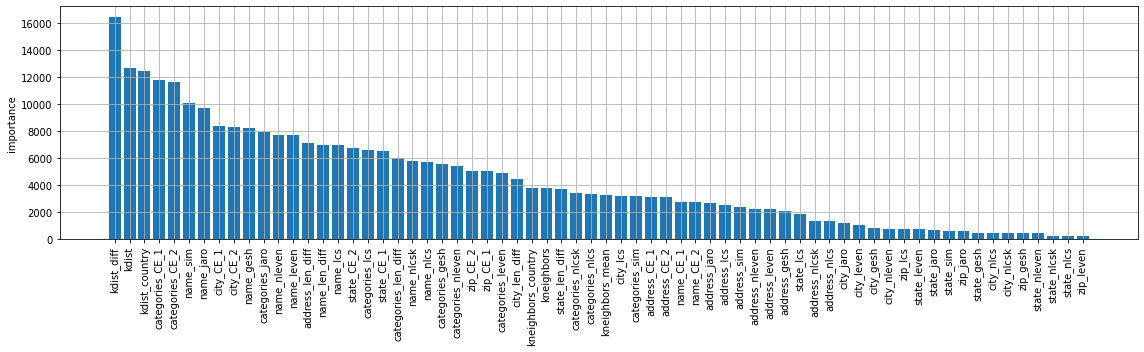

In [ ]:
def plot_importances(models):
    importance_df = pd.DataFrame(models[0].feature_importances_, 
                                 index=features, 
                                 columns=['importance'])\
                        .sort_values("importance", ascending=False)

    plt.subplots(figsize=(len(features) // 4, 5))
    plt.bar(importance_df.index, importance_df.importance)
    plt.grid()
    plt.xticks(rotation=90)
    plt.ylabel("importance")
    plt.tight_layout()
    plt.show()

plot_importances(models)

#Check CV

In [ ]:
test_data = add_features(test_data)
pred = inference_lgb(models, test_data[features])
test_data['pred'] = pred[:, 1]

  0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
def post_process(df):
    id2match = dict(zip(df['id'].values, df['matches'].str.split()))

    for base, match in df[['id', 'matches']].values:
        match = match.split()
        if len(match) == 1:        
            continue

        for m in match:
            if base not in id2match[m]:
                id2match[m].append(base)
    df['matches'] = df['id'].map(id2match).map(' '.join)
    return df 

In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import optuna

def objective(trial):
    x = trial.suggest_uniform('threshold', 0, 1)
    test_pred_df = test_data[test_data['pred'] > x][['id', 'match_id']]
    out_df = pd.DataFrame()
    out_df['id'] = test_data['id'].unique().tolist()
    out_df['match_id'] = out_df['id']
    out_df = pd.concat([out_df, test_pred_df])
    out_df = out_df.groupby('id')['match_id'].\
                        apply(list).reset_index()
    out_df['matches'] = out_df['match_id'].apply(lambda x: ' '.join(set(x)))
    out_df = post_process(out_df)

    score = get_score(out_df)
    print(f"CV: {score:.6f}")
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2022-05-29 18:58:04,107] A new study created in memory with name: no-name-96ab6b1f-d308-44b8-b976-07e651638316
[I 2022-05-29 18:58:43,789] Trial 0 finished with value: 0.8412053770936264 and parameters: {'threshold': 0.47067570757259647}. Best is trial 0 with value: 0.8412053770936264.


CV: 0.841205


[I 2022-05-29 18:59:02,243] Trial 1 finished with value: 0.8125302027313818 and parameters: {'threshold': 0.932317932860765}. Best is trial 0 with value: 0.8412053770936264.


CV: 0.812530


[I 2022-05-29 18:59:22,001] Trial 2 finished with value: 0.8344960443878446 and parameters: {'threshold': 0.8055233189641724}. Best is trial 0 with value: 0.8412053770936264.


CV: 0.834496


[I 2022-05-29 18:59:41,641] Trial 3 finished with value: 0.8297095738933771 and parameters: {'threshold': 0.2617543681051143}. Best is trial 0 with value: 0.8412053770936264.


CV: 0.829710


[I 2022-05-29 19:00:02,161] Trial 4 finished with value: 0.8231299644928627 and parameters: {'threshold': 0.20865284809526996}. Best is trial 0 with value: 0.8412053770936264.


CV: 0.823130


[I 2022-05-29 19:00:22,822] Trial 5 finished with value: 0.8041699138686226 and parameters: {'threshold': 0.12224138705417031}. Best is trial 0 with value: 0.8412053770936264.


CV: 0.804170


[I 2022-05-29 19:00:43,179] Trial 6 finished with value: 0.8316421843756592 and parameters: {'threshold': 0.28230899168442947}. Best is trial 0 with value: 0.8412053770936264.


CV: 0.831642


[I 2022-05-29 19:01:01,760] Trial 7 finished with value: 0.7566179891355077 and parameters: {'threshold': 0.9910169945880472}. Best is trial 0 with value: 0.8412053770936264.


CV: 0.756618


[I 2022-05-29 19:01:23,275] Trial 8 finished with value: 0.7736844827737724 and parameters: {'threshold': 0.06257778377551804}. Best is trial 0 with value: 0.8412053770936264.


CV: 0.773684


[I 2022-05-29 19:01:43,229] Trial 9 finished with value: 0.8421928489075617 and parameters: {'threshold': 0.5997366184580086}. Best is trial 9 with value: 0.8421928489075617.


CV: 0.842193


[I 2022-05-29 19:02:02,140] Trial 10 finished with value: 0.8416952156615957 and parameters: {'threshold': 0.649523124648099}. Best is trial 9 with value: 0.8421928489075617.


CV: 0.841695


[I 2022-05-29 19:02:22,161] Trial 11 finished with value: 0.8417645751927851 and parameters: {'threshold': 0.6434222699713039}. Best is trial 9 with value: 0.8421928489075617.


CV: 0.841765


[I 2022-05-29 19:02:41,430] Trial 12 finished with value: 0.8422947436950662 and parameters: {'threshold': 0.5540039272588637}. Best is trial 12 with value: 0.8422947436950662.


CV: 0.842295


[I 2022-05-29 19:03:02,059] Trial 13 finished with value: 0.8412327522782034 and parameters: {'threshold': 0.4734501351195186}. Best is trial 12 with value: 0.8422947436950662.


CV: 0.841233


[I 2022-05-29 19:03:22,163] Trial 14 finished with value: 0.842154945432379 and parameters: {'threshold': 0.6175368298537711}. Best is trial 12 with value: 0.8422947436950662.


CV: 0.842155


[I 2022-05-29 19:03:41,640] Trial 15 finished with value: 0.8387996231090666 and parameters: {'threshold': 0.3934697749650484}. Best is trial 12 with value: 0.8422947436950662.


CV: 0.838800


[I 2022-05-29 19:04:01,308] Trial 16 finished with value: 0.8348240796900405 and parameters: {'threshold': 0.8015504418937567}. Best is trial 12 with value: 0.8422947436950662.


CV: 0.834824


[I 2022-05-29 19:04:21,351] Trial 17 finished with value: 0.842288194187521 and parameters: {'threshold': 0.5725718177915369}. Best is trial 12 with value: 0.8422947436950662.


CV: 0.842288


[I 2022-05-29 19:04:40,652] Trial 18 finished with value: 0.837393483309134 and parameters: {'threshold': 0.7640726286443473}. Best is trial 12 with value: 0.8422947436950662.


CV: 0.837393


[I 2022-05-29 19:05:02,495] Trial 19 finished with value: 0.8357943137727113 and parameters: {'threshold': 0.3367932708561242}. Best is trial 12 with value: 0.8422947436950662.


CV: 0.835794


[I 2022-05-29 19:05:21,838] Trial 20 finished with value: 0.8422127435358595 and parameters: {'threshold': 0.539864117187953}. Best is trial 12 with value: 0.8422947436950662.


CV: 0.842213


[I 2022-05-29 19:05:41,735] Trial 21 finished with value: 0.842274181665445 and parameters: {'threshold': 0.5488094784236631}. Best is trial 12 with value: 0.8422947436950662.


CV: 0.842274


[I 2022-05-29 19:06:01,998] Trial 22 finished with value: 0.8402823087165423 and parameters: {'threshold': 0.4317394654131165}. Best is trial 12 with value: 0.8422947436950662.


CV: 0.840282


[I 2022-05-29 19:06:20,820] Trial 23 finished with value: 0.8394381779719683 and parameters: {'threshold': 0.7246780821117648}. Best is trial 12 with value: 0.8422947436950662.


CV: 0.839438


[I 2022-05-29 19:06:40,900] Trial 24 finished with value: 0.8422358106560749 and parameters: {'threshold': 0.5467933197547078}. Best is trial 12 with value: 0.8422947436950662.


CV: 0.842236


[I 2022-05-29 19:07:01,192] Trial 25 finished with value: 0.8369102635198332 and parameters: {'threshold': 0.35597969621502207}. Best is trial 12 with value: 0.8422947436950662.


CV: 0.836910


[I 2022-05-29 19:07:20,028] Trial 26 finished with value: 0.8403020334119125 and parameters: {'threshold': 0.7026880164985362}. Best is trial 12 with value: 0.8422947436950662.


CV: 0.840302


[I 2022-05-29 19:07:40,025] Trial 27 finished with value: 0.8422742756854267 and parameters: {'threshold': 0.5488356722017419}. Best is trial 12 with value: 0.8422947436950662.


CV: 0.842274


[I 2022-05-29 19:08:00,000] Trial 28 finished with value: 0.8303532436281329 and parameters: {'threshold': 0.8461463969516216}. Best is trial 12 with value: 0.8422947436950662.


CV: 0.830353


[I 2022-05-29 19:08:31,344] Trial 29 finished with value: 0.8413407432340183 and parameters: {'threshold': 0.47793599744596416}. Best is trial 12 with value: 0.8422947436950662.


CV: 0.841341


[I 2022-05-29 19:08:52,631] Trial 30 finished with value: 0.8403250149796713 and parameters: {'threshold': 0.7012697929701492}. Best is trial 12 with value: 0.8422947436950662.


CV: 0.840325


[I 2022-05-29 19:09:11,725] Trial 31 finished with value: 0.842214654602903 and parameters: {'threshold': 0.5426502770787321}. Best is trial 12 with value: 0.8422947436950662.


CV: 0.842215


[I 2022-05-29 19:09:31,704] Trial 32 finished with value: 0.8422854110543948 and parameters: {'threshold': 0.5657771423263016}. Best is trial 12 with value: 0.8422947436950662.


CV: 0.842285


[I 2022-05-29 19:09:51,859] Trial 33 finished with value: 0.8405116362908156 and parameters: {'threshold': 0.43887923359668907}. Best is trial 12 with value: 0.8422947436950662.


CV: 0.840512


[I 2022-05-29 19:10:10,925] Trial 34 finished with value: 0.8422190092406043 and parameters: {'threshold': 0.5975888723497463}. Best is trial 12 with value: 0.8422947436950662.


CV: 0.842219


[I 2022-05-29 19:10:31,111] Trial 35 finished with value: 0.8419106584843932 and parameters: {'threshold': 0.5081621590905896}. Best is trial 12 with value: 0.8422947436950662.


CV: 0.841911


[I 2022-05-29 19:10:50,202] Trial 36 finished with value: 0.8413936404200886 and parameters: {'threshold': 0.6612649157305951}. Best is trial 12 with value: 0.8422947436950662.


CV: 0.841394


[I 2022-05-29 19:11:10,271] Trial 37 finished with value: 0.83872046950866 and parameters: {'threshold': 0.3919844951911791}. Best is trial 12 with value: 0.8422947436950662.


CV: 0.838720


[I 2022-05-29 19:11:29,541] Trial 38 finished with value: 0.8184959459697811 and parameters: {'threshold': 0.9127377447471373}. Best is trial 12 with value: 0.8422947436950662.


CV: 0.818496


[I 2022-05-29 19:11:49,608] Trial 39 finished with value: 0.8422648280324664 and parameters: {'threshold': 0.5699800578337264}. Best is trial 12 with value: 0.8422947436950662.


CV: 0.842265


[I 2022-05-29 19:12:09,258] Trial 40 finished with value: 0.8237451397813519 and parameters: {'threshold': 0.2128930251199117}. Best is trial 12 with value: 0.8422947436950662.


CV: 0.823745


[I 2022-05-29 19:12:29,305] Trial 41 finished with value: 0.8419856554726651 and parameters: {'threshold': 0.5141292574184476}. Best is trial 12 with value: 0.8422947436950662.


CV: 0.841986


[I 2022-05-29 19:12:52,245] Trial 42 finished with value: 0.8422476385029323 and parameters: {'threshold': 0.5925968196475461}. Best is trial 12 with value: 0.8422947436950662.


CV: 0.842248


[I 2022-05-29 19:13:11,576] Trial 43 finished with value: 0.840548224866932 and parameters: {'threshold': 0.44032368632081265}. Best is trial 12 with value: 0.8422947436950662.


CV: 0.840548


[I 2022-05-29 19:13:31,348] Trial 44 finished with value: 0.8411374831506617 and parameters: {'threshold': 0.6695554603375424}. Best is trial 12 with value: 0.8422947436950662.


CV: 0.841137


[I 2022-05-29 19:13:51,439] Trial 45 finished with value: 0.841678414348827 and parameters: {'threshold': 0.49479039662149865}. Best is trial 12 with value: 0.8422947436950662.


CV: 0.841678


[I 2022-05-29 19:14:11,393] Trial 46 finished with value: 0.8418594287529995 and parameters: {'threshold': 0.6375169756612361}. Best is trial 12 with value: 0.8422947436950662.


CV: 0.841859


[I 2022-05-29 19:14:30,391] Trial 47 finished with value: 0.8382687060626212 and parameters: {'threshold': 0.7474815561711844}. Best is trial 12 with value: 0.8422947436950662.


CV: 0.838269


[I 2022-05-29 19:14:50,532] Trial 48 finished with value: 0.8422868068346928 and parameters: {'threshold': 0.5770671183264094}. Best is trial 12 with value: 0.8422947436950662.


CV: 0.842287


[I 2022-05-29 19:15:09,330] Trial 49 finished with value: 0.8421679677939841 and parameters: {'threshold': 0.6115599189007768}. Best is trial 12 with value: 0.8422947436950662.


CV: 0.842168


[I 2022-05-29 19:15:29,618] Trial 50 finished with value: 0.8335465120874842 and parameters: {'threshold': 0.3055628666075336}. Best is trial 12 with value: 0.8422947436950662.


CV: 0.833547


[I 2022-05-29 19:15:49,626] Trial 51 finished with value: 0.8422652716324939 and parameters: {'threshold': 0.5697607785490078}. Best is trial 12 with value: 0.8422947436950662.


CV: 0.842265


[I 2022-05-29 19:16:08,734] Trial 52 finished with value: 0.8420499641150719 and parameters: {'threshold': 0.5191726441627514}. Best is trial 12 with value: 0.8422947436950662.


CV: 0.842050


[I 2022-05-29 19:16:29,034] Trial 53 finished with value: 0.8410066959341246 and parameters: {'threshold': 0.46309591504606346}. Best is trial 12 with value: 0.8422947436950662.


CV: 0.841007


[I 2022-05-29 19:16:49,187] Trial 54 finished with value: 0.8422854470216045 and parameters: {'threshold': 0.5666961958223374}. Best is trial 12 with value: 0.8422947436950662.


CV: 0.842285


[I 2022-05-29 19:17:09,239] Trial 55 finished with value: 0.8413198732003389 and parameters: {'threshold': 0.6652991156725901}. Best is trial 12 with value: 0.8422947436950662.


CV: 0.841320


[I 2022-05-29 19:17:28,501] Trial 56 finished with value: 0.8391221312772472 and parameters: {'threshold': 0.39887005961891053}. Best is trial 12 with value: 0.8422947436950662.


CV: 0.839122


[I 2022-05-29 19:17:48,271] Trial 57 finished with value: 0.84207878939093 and parameters: {'threshold': 0.6231911857889498}. Best is trial 12 with value: 0.8422947436950662.


CV: 0.842079


[I 2022-05-29 19:18:08,222] Trial 58 finished with value: 0.8422371445563203 and parameters: {'threshold': 0.5804220305256191}. Best is trial 12 with value: 0.8422947436950662.


CV: 0.842237


[I 2022-05-29 19:18:27,080] Trial 59 finished with value: 0.8353414919244093 and parameters: {'threshold': 0.793869705697047}. Best is trial 12 with value: 0.8422947436950662.


CV: 0.835341


[I 2022-05-29 19:18:50,804] Trial 60 finished with value: 0.8407223312837006 and parameters: {'threshold': 0.6888787331901167}. Best is trial 12 with value: 0.8422947436950662.


CV: 0.840722


[I 2022-05-29 19:19:12,031] Trial 61 finished with value: 0.842196164415188 and parameters: {'threshold': 0.5365150141209205}. Best is trial 12 with value: 0.8422947436950662.


CV: 0.842196


[I 2022-05-29 19:19:31,933] Trial 62 finished with value: 0.8422869166655129 and parameters: {'threshold': 0.5635523897448915}. Best is trial 12 with value: 0.8422947436950662.


CV: 0.842287


[I 2022-05-29 19:19:50,872] Trial 63 finished with value: 0.8419934596785553 and parameters: {'threshold': 0.6274465390118726}. Best is trial 12 with value: 0.8422947436950662.


CV: 0.841993


[I 2022-05-29 19:20:11,074] Trial 64 finished with value: 0.8415996217889141 and parameters: {'threshold': 0.490939671353894}. Best is trial 12 with value: 0.8422947436950662.


CV: 0.841600


[I 2022-05-29 19:20:31,141] Trial 65 finished with value: 0.8422596476016354 and parameters: {'threshold': 0.5707345201826951}. Best is trial 12 with value: 0.8422947436950662.


CV: 0.842260


[I 2022-05-29 19:20:50,590] Trial 66 finished with value: 0.8409237562041852 and parameters: {'threshold': 0.4576844957417283}. Best is trial 12 with value: 0.8422947436950662.


CV: 0.840924


[I 2022-05-29 19:21:10,657] Trial 67 finished with value: 0.8396054776625305 and parameters: {'threshold': 0.4112525931380604}. Best is trial 12 with value: 0.8422947436950662.


CV: 0.839605


[I 2022-05-29 19:21:30,776] Trial 68 finished with value: 0.8420057625822938 and parameters: {'threshold': 0.5159604137461244}. Best is trial 12 with value: 0.8422947436950662.


CV: 0.842006


[I 2022-05-29 19:21:50,971] Trial 69 finished with value: 0.8369791886751252 and parameters: {'threshold': 0.35752549594753624}. Best is trial 12 with value: 0.8422947436950662.


CV: 0.836979


[I 2022-05-29 19:22:12,612] Trial 70 finished with value: 0.722478648367928 and parameters: {'threshold': 0.02582743871991794}. Best is trial 12 with value: 0.8422947436950662.


CV: 0.722479


[I 2022-05-29 19:22:32,576] Trial 71 finished with value: 0.8422607763377635 and parameters: {'threshold': 0.5485398737709858}. Best is trial 12 with value: 0.8422947436950662.


CV: 0.842261


[I 2022-05-29 19:22:52,426] Trial 72 finished with value: 0.8421906697283968 and parameters: {'threshold': 0.5997462949794189}. Best is trial 12 with value: 0.8422947436950662.


CV: 0.842191


[I 2022-05-29 19:23:12,346] Trial 73 finished with value: 0.8422643459508824 and parameters: {'threshold': 0.5505268551686612}. Best is trial 12 with value: 0.8422947436950662.


CV: 0.842264


[I 2022-05-29 19:23:31,413] Trial 74 finished with value: 0.8395100238827268 and parameters: {'threshold': 0.7232126078375496}. Best is trial 12 with value: 0.8422947436950662.


CV: 0.839510


[I 2022-05-29 19:23:51,591] Trial 75 finished with value: 0.8415379691373398 and parameters: {'threshold': 0.4887947950517386}. Best is trial 12 with value: 0.8422947436950662.


CV: 0.841538


[I 2022-05-29 19:24:11,519] Trial 76 finished with value: 0.8417678107996589 and parameters: {'threshold': 0.6438268216554444}. Best is trial 12 with value: 0.8422947436950662.


CV: 0.841768


[I 2022-05-29 19:24:31,656] Trial 77 finished with value: 0.8422653703083294 and parameters: {'threshold': 0.5684381470485923}. Best is trial 12 with value: 0.8422947436950662.


CV: 0.842265


[I 2022-05-29 19:24:51,757] Trial 78 finished with value: 0.842153358462942 and parameters: {'threshold': 0.6065429509728091}. Best is trial 12 with value: 0.8422947436950662.


CV: 0.842153


[I 2022-05-29 19:25:11,364] Trial 79 finished with value: 0.8421485493094274 and parameters: {'threshold': 0.5297224268765593}. Best is trial 12 with value: 0.8422947436950662.


CV: 0.842149


[I 2022-05-29 19:25:31,687] Trial 80 finished with value: 0.8402354461445082 and parameters: {'threshold': 0.43078792560233536}. Best is trial 12 with value: 0.8422947436950662.


CV: 0.840235


[I 2022-05-29 19:25:50,725] Trial 81 finished with value: 0.8422836739003624 and parameters: {'threshold': 0.5719860753215229}. Best is trial 12 with value: 0.8422947436950662.


CV: 0.842284


[I 2022-05-29 19:26:10,683] Trial 82 finished with value: 0.8422652580020421 and parameters: {'threshold': 0.5648291623645239}. Best is trial 12 with value: 0.8422947436950662.


CV: 0.842265


[I 2022-05-29 19:26:30,652] Trial 83 finished with value: 0.8409571247578915 and parameters: {'threshold': 0.6808822459933944}. Best is trial 12 with value: 0.8422947436950662.


CV: 0.840957


[I 2022-05-29 19:26:50,720] Trial 84 finished with value: 0.8422228499477776 and parameters: {'threshold': 0.5942536143019543}. Best is trial 12 with value: 0.8422947436950662.


CV: 0.842223


[I 2022-05-29 19:27:10,821] Trial 85 finished with value: 0.8419760187938476 and parameters: {'threshold': 0.6292331443614787}. Best is trial 12 with value: 0.8422947436950662.


CV: 0.841976


[I 2022-05-29 19:27:30,027] Trial 86 finished with value: 0.8418595917174706 and parameters: {'threshold': 0.5043966903006942}. Best is trial 12 with value: 0.8422947436950662.


CV: 0.841860


[I 2022-05-29 19:27:50,139] Trial 87 finished with value: 0.8412238854320301 and parameters: {'threshold': 0.4720804042529681}. Best is trial 12 with value: 0.8422947436950662.


CV: 0.841224


[I 2022-05-29 19:28:09,212] Trial 88 finished with value: 0.8415243039047011 and parameters: {'threshold': 0.6564153049840952}. Best is trial 12 with value: 0.8422947436950662.


CV: 0.841524


[I 2022-05-29 19:28:29,278] Trial 89 finished with value: 0.8421955150863167 and parameters: {'threshold': 0.5371372336345913}. Best is trial 12 with value: 0.8422947436950662.


CV: 0.842196


[I 2022-05-29 19:28:49,289] Trial 90 finished with value: 0.8422579006269422 and parameters: {'threshold': 0.5875278341191836}. Best is trial 12 with value: 0.8422947436950662.


CV: 0.842258


[I 2022-05-29 19:29:09,265] Trial 91 finished with value: 0.8422897379256599 and parameters: {'threshold': 0.55629834300704}. Best is trial 12 with value: 0.8422947436950662.


CV: 0.842290


[I 2022-05-29 19:29:29,493] Trial 92 finished with value: 0.8422793640129134 and parameters: {'threshold': 0.5531293304474002}. Best is trial 12 with value: 0.8422947436950662.


CV: 0.842279


[I 2022-05-29 19:29:48,473] Trial 93 finished with value: 0.8421725770697008 and parameters: {'threshold': 0.6122465480981323}. Best is trial 12 with value: 0.8422947436950662.


CV: 0.842173


[I 2022-05-29 19:30:08,684] Trial 94 finished with value: 0.8421283181088218 and parameters: {'threshold': 0.5228492617700877}. Best is trial 12 with value: 0.8422947436950662.


CV: 0.842128


[I 2022-05-29 19:30:28,146] Trial 95 finished with value: 0.8422894042231763 and parameters: {'threshold': 0.5547355632149755}. Best is trial 12 with value: 0.8422947436950662.


CV: 0.842289


[I 2022-05-29 19:30:48,379] Trial 96 finished with value: 0.8422899043020814 and parameters: {'threshold': 0.5551735213578282}. Best is trial 12 with value: 0.8422947436950662.


CV: 0.842290


[I 2022-05-29 19:31:08,487] Trial 97 finished with value: 0.8422324820298379 and parameters: {'threshold': 0.5825693867448877}. Best is trial 12 with value: 0.8422947436950662.


CV: 0.842232


[I 2022-05-29 19:31:27,841] Trial 98 finished with value: 0.8408010473112651 and parameters: {'threshold': 0.4513530081558804}. Best is trial 12 with value: 0.8422947436950662.


CV: 0.840801


[I 2022-05-29 19:31:47,841] Trial 99 finished with value: 0.8417490416474854 and parameters: {'threshold': 0.49973289665052323}. Best is trial 12 with value: 0.8422947436950662.


CV: 0.841749


In [ ]:
threshold = study.best_params['threshold']
threshold

0.5540039272588637

In [ ]:
study.best_value

0.8422947436950662

In [ ]:
test_pred_df = test_data[test_data['pred'] > threshold][['id', 'match_id']]
out_df = pd.DataFrame()
out_df['id'] = test_data['id'].unique().tolist()
out_df['match_id'] = out_df['id']
out_df = pd.concat([out_df, test_pred_df])
out_df = out_df.groupby('id')['match_id'].\
                    apply(list).reset_index()
out_df['matches'] = out_df['match_id'].apply(lambda x: ' '.join(set(x)))
out_df = post_process(out_df)

score = get_score(out_df)
print(f"CV: {score:.6f}")

CV: 0.842295


# 間違っているものの中身を見る

In [ ]:
data = data.reset_index()

labelが1なのに0と予測しているもの

In [ ]:
false_negative = test_data.loc[(test_data["label"] == 1) & (test_data["pred"] <= threshold), :]
false_negative.describe()

,kdist,kneighbors,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,name_sim,name_gesh,name_leven,...,categories_leven,categories_jaro,categories_lcs,categories_CE_1,categories_CE_2,categories_len_diff,categories_nleven,categories_nlcsk,categories_nlcs,pred
count,125285.000000,125285.000000,121384.000000,121384.000000,116037.000000,129298.000000,129298.0,129298.000000,129298.000000,129298.000000,...,95605.000000,95605.000000,95605.000000,1.093510e+05,1.094970e+05,129298.000000,95605.000000,95605.000000,95605.000000,1.292980e+05
mean,0.006941,6.375576,0.003572,6.403916,0.428645,6.679867,1.0,0.261855,0.406009,16.773794,...,12.612416,0.673425,9.107024,4.926382e-03,4.926495e-03,9.218457,0.538891,0.580205,0.580742,1.818070e-01
std,0.058225,5.272830,0.024521,5.279583,2.461463,5.329216,0.0,0.295295,0.246352,9.460851,...,11.692514,0.243484,7.353422,5.943582e-03,5.939460e-03,11.085131,0.352942,0.330293,0.329730,1.721260e-01
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,8.781081e-07,8.781081e-07,0.000000,0.000000,0.000000,0.000000,4.437365e-10
25%,0.000457,2.000000,0.000341,2.000000,0.005639,2.000000,1.0,0.000000,0.208955,10.000000,...,0.000000,0.482776,4.000000,6.647278e-04,6.647278e-04,0.000000,0.000000,0.285714,0.285714,2.425433e-02
50%,0.001148,5.000000,0.000884,5.000000,0.057228,5.000000,1.0,0.169605,0.388889,16.000000,...,12.000000,0.581737,7.000000,2.539489e-03,2.539489e-03,6.000000,0.714286,0.478261,0.476190,1.255413e-01
75%,0.003118,10.000000,0.002400,10.000000,0.320393,10.500000,1.0,0.485067,0.580645,22.000000,...,17.000000,1.000000,12.000000,6.329403e-03,6.329403e-03,13.000000,0.823529,1.000000,1.000000,3.194673e-01
max,4.310371,19.000000,2.388985,19.000000,214.206825,19.000000,1.0,1.000000,1.000000,59.000000,...,87.000000,1.000000,77.000000,2.237507e-02,2.237507e-02,90.000000,1.000000,1.000000,1.000000,5.539889e-01


In [ ]:
false_negative.sample(min(false_negative.shape[0], 30))

,id,match_id,kdist,kneighbors,point_of_interest,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,...,categories_leven,categories_jaro,categories_lcs,categories_CE_1,categories_CE_2,categories_len_diff,categories_nleven,categories_nlcsk,categories_nlcs,pred
1092765,E_eb273b66a61577,E_6acff4fc28ecdd,0.000046,1.0,P_e8364797b7e020,0.000038,1.0,0.204397,1.0,1,...,27.0,0.494270,6.0,8.781081e-07,8.429837e-04,20,0.818182,0.461538,0.181818,0.160597
3478281,E_1bb4d8d753e28a,E_afd390bb4892ef,0.000177,6.0,P_420422c1d41b2c,0.000176,6.0,0.002493,6.0,1,...,NaN,NaN,NaN,NaN,2.132924e-03,14,NaN,NaN,NaN,0.350362
7241391,E_b75b8b9e95c37c,E_f3fa51f58a8b60,0.002721,12.0,P_e47d5b95182027,0.002453,12.0,0.109102,12.0,1,...,0.0,1.000000,12.0,7.082820e-03,7.082820e-03,0,0.000000,1.000000,1.000000,0.405190
1246117,E_30198c21e8744c,E_9c805d6f8e52e8,0.000807,2.0,P_1192674e68c7d6,0.000712,2.0,0.134147,2.0,1,...,NaN,NaN,NaN,NaN,3.327151e-03,17,NaN,NaN,NaN,0.070976
2472287,E_57624c7806d014,E_c9040f0e581c1e,0.002853,4.0,P_6c385e5fd3a4b7,0.002836,4.0,0.006088,4.0,1,...,NaN,NaN,NaN,1.447122e-03,NaN,13,NaN,NaN,NaN,0.007622
1963742,E_72c4e057154d7b,E_05916950155b70,0.000881,3.0,P_3482a5f7956ffb,0.000881,3.0,0.000256,3.0,1,...,0.0,1.000000,15.0,2.183855e-03,2.183855e-03,0,0.000000,1.000000,1.000000,0.490856
3824813,E_b74b0170e7bb02,E_9624b022a50b5c,0.072145,6.0,NaN,NaN,NaN,NaN,6.0,1,...,16.0,0.457557,7.0,5.629551e-03,3.512432e-06,16,0.695652,0.304348,1.000000,0.012058
5775936,E_24b162340aac89,E_66347106c351eb,0.002175,10.0,P_49f2caf18a599c,0.002169,12.0,0.002439,11.0,1,...,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,0.022754
7270672,E_c49d7d7396f3f7,E_ac5bdcff3109a3,0.000249,12.0,P_e8f925e0e5b93d,0.000245,12.0,0.016945,12.0,1,...,17.0,0.546498,6.0,2.370892e-05,1.081829e-03,11,0.739130,0.500000,0.260870,0.002226
6902436,E_1f30d8c5a57276,E_4e4f9f232df0b3,0.001380,12.0,P_3e19e4a6943957,0.001349,12.0,0.022971,12.0,1,...,23.0,0.596591,13.0,5.488175e-04,8.781081e-07,10,0.718750,0.406250,0.590909,0.004576


In [ ]:
for id, match_id in false_negative.sample(min(false_negative.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
593133,E_854e3b8d9fcb0f,Super Target,31.749380,-106.284846,NaN,El Paso,TX,79936,US,NaN,NaN,Grocery Stores,P_3eafb711e3b844,2,1.0
1052421,E_ec776701548d45,Target,31.758907,-106.265330,1874 Joe Battle Blvd,El Paso,TX,79936,US,http://www.target.com,9158495010,"Big Box Stores, Department Stores",P_3eafb711e3b844,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
677997,E_984c39a6608b0e,Кафе Парфэ,59.936711,30.317697,Большая Морская 2,NaN,NaN,NaN,RU,NaN,NaN,"Cafés, Dessert Shops, Eastern European Restaur...",P_da3f880777c01e,1,1.0
1044412,E_eaae47d63e4b28,Cafe Parfe,59.936761,30.317626,NaN,NaN,NaN,NaN,RU,NaN,NaN,Cafés,P_da3f880777c01e,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
642321,E_9063e7f186e7ad,Acıbadem ameliyathane,39.784669,30.494979,NaN,NaN,NaN,NaN,TR,NaN,NaN,Hospitals,P_3d04642c63888e,4,1.0
738972,E_a601758733ad44,Acıbadem Hastanesi MSÜ,39.784866,30.495302,NaN,NaN,NaN,NaN,TR,NaN,NaN,Hospitals,P_3d04642c63888e,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
111107,E_18e662a4a3871e,Revenue Pakkred,13.927832,100.532641,ถนนบอนด์สตรีทหมู่บ้านเมืองทองธานี,บ้านใหม่,จ.นนทบุรี,11120,TH,NaN,NaN,Government Buildings,P_6f981e59723a47,2,1.0
288963,E_40e29202dee36a,สำนักงานสรรพากรพื้นที่สาขาปากเกร็ด 2,13.927805,100.532712,NaN,NaN,NaN,NaN,TH,NaN,NaN,Buildings,P_6f981e59723a47,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
827935,E_b9ebeca0c6c5a3,Birkenstock,25.042852,121.505909,NaN,NaN,NaN,NaN,TW,NaN,NaN,Shoe Repair Shops,P_99cd24add8c463,2,1.0
1027064,E_e6c2ae62045cb9,德國勃肯 BIRKENSTOCK（古著行紅樓）,25.042234,121.506061,西寧南路88-1號,萬華區,台北市,108,TW,http://www.birkenstock.com.tw,+886223888277,Shoe Stores,P_99cd24add8c463,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
230561,E_33c197afac1d5a,F301 - Ateneo de Davao University,7.072046,125.613016,NaN,NaN,NaN,NaN,PH,NaN,NaN,College Academic Buildings,P_4dd72a29a64d61,4,1.0
1056454,E_ed67f4dc9ed0b6,Ateneo De Davao University Jacinto Campus,7.072685,125.613486,E. Jacinto St.,Davao City,Davao Region,NaN,PH,NaN,NaN,Universities,P_4dd72a29a64d61,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
374071,E_540b65f5960a0e,Coca Steamboat,1.305940,103.830805,"#02-05/08, International Building",Singapore,Singapore,238869,SG,NaN,6567382588,"Chinese Restaurants, Soup Places, Hotpot Resta...",P_45185a9f7d2404,2,1.0
988032,E_ddf9f1a6d9ecfb,Coca Shaw House,1.306306,103.830714,Shaw House,NaN,NaN,NaN,SG,NaN,NaN,Chinese Restaurants,P_45185a9f7d2404,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
426879,E_5fec8ce620b444,Uroko Tei Ironai,43.202815,140.996847,NaN,小樽市,北海道,NaN,JP,NaN,NaN,Japanese Restaurants,P_ce5d92ad7218f6,2,1.0
819351,E_b8002673a95ab1,うろこ番屋,43.200141,141.001065,NaN,NaN,NaN,NaN,JP,NaN,NaN,Japanese Restaurants,P_ce5d92ad7218f6,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
177219,E_27c029d48b3d7a,Stuyvesant Town,40.732415,-73.979055,252 First Ave,New York,NY,10009,US,http://www.pcvst.com,2124205000,Residential Buildings (Apartments / Condos),P_fc67e6d06af9c1,2,1.0
832765,E_bb018c0bc7f02d,StuyTown Apartments,40.732468,-73.980888,252 1st Ave,New York,NY,10009,US,https://www.stuytown.com/no-fee-apartments-nyc,+16466791418,Housing Developments,P_fc67e6d06af9c1,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
109237,E_187aa4f006fd7b,Cruise Land,48.862045,2.282553,NaN,NaN,NaN,NaN,FR,NaN,NaN,NaN,P_9e3a622db5e1a0,2,1.0
1131011,E_fe3d87ad1e7413,Air India,48.862144,2.282617,NaN,NaN,NaN,NaN,FR,NaN,NaN,NaN,P_9e3a622db5e1a0,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
372408,E_53adc6c745d20a,Otobüs Terminali Aşti Ankara,39.918374,32.812243,Ankara,Ankara,NaN,NaN,TR,NaN,NaN,Bus Stops,P_0c47b60beca9b9,4,1.0
808038,E_b5754d3a47fdd0,Nilüfer Bursa Otobüsü,39.917510,32.812418,NaN,NaN,NaN,NaN,TR,NaN,NaN,General Travel,P_0c47b60beca9b9,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
786256,E_b09ffc7ef075e7,Зоя Михайловна,56.848654,60.607473,"ул. Лермонтова, 11",Екатеринбург,Свердловская обл.,NaN,RU,NaN,NaN,Auditoriums,P_c49f8ba585d020,4,1.0
1055335,E_ed262a8772cd05,Информатика 420 каб.,56.848051,60.607168,NaN,NaN,NaN,NaN,RU,NaN,NaN,Auditoriums,P_c49f8ba585d020,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
841143,E_bce656c1acbe56,fed ex,33.501080,-112.151106,NaN,Phoenix,AZ,85019,US,NaN,NaN,NaN,P_9d38b415b02639,1,1.0
1031157,E_e7aea424f2452b,FedEx Ship Center,33.501089,-112.151157,4475 N 43rd Ave,Phoenix,AZ,85031,US,https://local.fedex.com/en-us/az/phoenix/lufa/,8004633339,"Shipping Stores, Business Services",P_9d38b415b02639,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
624174,E_8c55eeab8dc599,Praia da Pipa,-6.228366,-35.050719,NaN,Tibau do Sul,RN,NaN,BR,NaN,NaN,Beaches,P_6142326eb038a0,3,1.0
1071797,E_f0e033d8d615b3,Pipa,-6.232880,-35.044415,NaN,NaN,Rio Grande do Norte,59178-000,BR,NaN,NaN,General Travel,P_6142326eb038a0,3,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
809004,E_b5ad0b56486b56,Dinas Kesehatan Prov. Sumbar,-0.939182,100.365837,Jl. Perintis Kemerdekaan No. 65A,Padang,Sumatera Barat,NaN,ID,NaN,NaN,"Offices, Government Buildings",P_53b22f18df0a29,3,1.0
1118591,E_fb7864c1969eaf,Dinas kesehatan provinsi sumbar,-0.940832,100.363143,Jl. Perintis Kemerdekaan No.65A Padang,Padang,Sumatera Barat,NaN,ID,NaN,NaN,NaN,P_53b22f18df0a29,3,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
414814,E_5d334642a77370,Target Pharmacy,30.455014,-90.133555,NaN,Covington,LA,70433,US,NaN,NaN,Buildings,P_fe7c1c74fe2b01,1,1.0
686427,E_9a291a07d527d9,Target,30.442847,-90.141082,69320 Highway 21,Covington,LA,70433,US,https://www.target.com/sl/covington/1876,9858717093,"Big Box Stores, Department Stores",P_fe7c1c74fe2b01,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
454376,E_661c89ce8709ab,goedefroo en goedefroo architectenburo,50.903965,3.371658,NaN,NaN,NaN,NaN,BE,NaN,NaN,Buildings,P_f7503ae18036f6,1,1.0
567667,E_7f96f28baa78b4,Goedefroo & Goedefroo Architecten,50.903767,3.371619,Ooigemstraat 2,Wielsbeke,Vlaams Gewest,NaN,BE,NaN,NaN,"Offices, Buildings",P_f7503ae18036f6,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
633008,E_8e53587e4aa3de,kumara-moision puheopissa,61.568562,23.598721,NaN,NaN,NaN,NaN,FI,NaN,NaN,College Classrooms,P_529b2937cef756,4,1.0
779489,E_af14e62920ca9b,Moision koulu,61.568902,23.600641,Kuusistontie 1,Ylöjärvi,NaN,33480,FI,NaN,NaN,"Schools, High Schools",P_529b2937cef756,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
424193,E_5f4cc1a754ec62,parque alberto hurtado,-33.433158,-70.558922,Bilbao,NaN,NaN,NaN,CL,NaN,NaN,Parks,P_5619f82fcda6de,4,1.0
654047,E_92fbb0a40a7afd,Parque Padre Hurtado,-33.430105,-70.547639,Francisco Bilbao 8105,La Reina,Región Metropolitana,NaN,CL,NaN,NaN,"Parks, Dog Runs",P_5619f82fcda6de,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
530864,E_774c901479d34a,AutoNation Buick GMC Henderson,36.051830,-115.027813,330 North Gibson Road,Henderson,NV,89014,US,https://www.autonationbuickgmchenderson.com,+17029792044,"Auto Dealerships, Automotive Shops",P_c6f22d5047cfa7,2,1.0
992529,E_def7ab84f8d92b,desert valley gmc buick parts department,36.051655,-115.027946,NaN,Henderson,NV,NaN,US,NaN,NaN,Gas Stations,P_c6f22d5047cfa7,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
127970,E_1caffc1d63ebb1,УКИТ,55.750149,37.667431,"Костомаровская наб., 29",Москва,Москва,105120,RU,NaN,4959170282,"General Colleges & Universities, Community Col...",P_d1a1d6dc517d18,2,1.0
620691,E_8b8ee02dd37646,MGKIT,55.750565,37.667496,NaN,NaN,NaN,NaN,RU,NaN,NaN,General Colleges & Universities,P_d1a1d6dc517d18,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
374973,E_544017bb028635,Церковь Святого Николая,51.053944,3.722954,NaN,Gent,Vlaanderen,9000,BE,NaN,NaN,Churches,P_59908760ae08a6,1,1.0
497765,E_6fe6d474df9384,Sint-Niklaaskerk,51.054019,3.722538,Cataloniëstraat 1,Gent,Oost-Vlaanderen,9000,BE,http://www.sintniklaaskerk.be,NaN,"Churches, Historic Sites, Event Spaces",P_59908760ae08a6,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
862348,E_c1b265c7713705,"Ленинский, 119 к4",59.850473,30.259606,NaN,NaN,NaN,NaN,RU,NaN,NaN,Residential Buildings (Apartments / Condos),P_4e864176258158,2,1.0
989259,E_de3f3ad8dec9ef,Ленинский Д 119 К 4,59.850758,30.259424,Ленинский 119 К. 4,Сайнт П,Русса,NaN,RU,NaN,NaN,Residential Buildings (Apartments / Condos),P_4e864176258158,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
781693,E_af947f792f8fb3,Giant Hypermarket,2.989626,101.572644,"3, Persiaran Putra Perdana",Subang Jaya,Selangor,47650,MY,http://www.giant.com.my,351927008,Department Stores,P_ea8b6d474d0c98,2,1.0
968802,E_d99f03c071d502,Giant Putra Heights,2.989114,101.572052,Putra Heights,Selangor,Malaysia,NaN,MY,NaN,NaN,Convenience Stores,P_ea8b6d474d0c98,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
60812,E_0d9c947566a6f2,mersin marina,36.770714,34.569645,NaN,NaN,NaN,NaN,TR,NaN,NaN,Cafés,P_8d2f8c73179d93,4,1.0
866614,E_c2ab13df890eae,Marina Yat Limanı,36.771868,34.571320,NaN,NaN,NaN,NaN,TR,NaN,NaN,Harbors / Marinas,P_8d2f8c73179d93,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
433745,E_617fd8ee474596,Perron B,51.807504,4.670332,Busstation Centraal Station,Dordrecht,Zuid-Holland,NaN,NL,NaN,NaN,Bus Stops,P_5f917e5b1c9872,3,1.0
694007,E_9be23594d8c38e,Perron D,51.807455,4.669510,Busstation Centraal Station,Dordrecht,Zuid-Holland,3311 JG,NL,NaN,NaN,Bus Stops,P_5f917e5b1c9872,3,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
399793,E_59d4cb48db8cb6,Santuario de San Antonio Columbarium,14.547376,121.036564,Forbes Park,Makati City,NaN,NaN,PH,NaN,NaN,Spiritual Centers,P_4293602e54d806,3,1.0
1086865,E_f438b57047926f,Adoration Chapel - Santuario de San Antonio,14.546656,121.033406,McKinley Rd,Makati City,NCR,NaN,PH,NaN,NaN,Temples,P_4293602e54d806,3,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
103711,E_173fd6762bae07,Риторика-уморика,55.649216,37.501692,"РУДН, Аграрный ф-т",NaN,NaN,NaN,RU,NaN,NaN,NaN,P_2df67bfb407545,4,1.0
1102324,E_f7c0fc608dd9b6,Паразитология,55.650820,37.503156,NaN,NaN,NaN,NaN,RU,NaN,NaN,NaN,P_2df67bfb407545,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
757226,E_aa1b649ae42445,Aberdeen Centre Minibus Stop 香港仔中心小巴站,22.247622,114.155296,Wu Nam St,Aberdeen,NaN,NaN,HK,NaN,NaN,Bus Stations,P_e971a41913432e,1,1.0
977038,E_db7da3bac398ab,小巴站(經西隧去旺角) Nam Ning Street,22.248671,114.155190,NaN,NaN,NaN,NaN,HK,NaN,NaN,NaN,P_e971a41913432e,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
47546,E_0aa2b12666a6f6,Bahnreisezentrum,47.450195,8.562677,Bahnhof Zürich Flughafen,Kloten,ZH,8302,CH,http://www.sbb.ch,NaN,Travel Agencies,P_c9b467b677793e,2,1.0
263846,E_3b4083fcb4cf0d,Railway Center,47.448963,8.564908,NaN,NaN,NaN,NaN,CH,NaN,NaN,NaN,P_c9b467b677793e,2,1.0


labelが0なのに1と予測しているもの

In [ ]:
false_positive = test_data.loc[(test_data["label"] == 0) & (test_data["pred"] > threshold), :]
false_positive.describe()

,kdist,kneighbors,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,name_sim,name_gesh,name_leven,...,categories_leven,categories_jaro,categories_lcs,categories_CE_1,categories_CE_2,categories_len_diff,categories_nleven,categories_nlcsk,categories_nlcs,pred
count,49005.000000,49005.000000,47589.000000,47589.000000,46383.000000,49729.000000,49729.0,49729.000000,49720.000000,49720.000000,...,40462.000000,40462.000000,40462.000000,4.431500e+04,4.429600e+04,49729.000000,40462.000000,40462.000000,40462.000000,49729.000000
mean,0.006152,4.409305,0.002742,4.411166,0.414902,4.630648,0.0,0.506821,0.590791,12.644771,...,10.278558,0.776864,11.160941,4.698359e-03,4.676817e-03,8.771321,0.388556,0.725556,0.726674,0.790116
std,0.127485,4.707752,0.012021,4.695900,1.767695,4.819232,0.0,0.340869,0.262593,9.551353,...,12.145011,0.239736,7.736219,5.680718e-03,5.680730e-03,11.630502,0.363977,0.325236,0.325465,0.138507
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,8.781081e-07,8.781081e-07,0.000000,0.000000,0.000000,0.000000,0.554022
25%,0.000291,1.000000,0.000224,1.000000,0.007575,1.000000,0.0,0.225636,0.413793,5.000000,...,0.000000,0.533761,5.000000,5.277429e-04,5.242305e-04,0.000000,0.000000,0.400000,0.407596,0.665861
50%,0.000801,2.000000,0.000615,2.000000,0.066032,2.000000,0.0,0.547612,0.612245,11.000000,...,8.000000,0.875000,10.000000,2.521926e-03,2.521926e-03,4.000000,0.450000,1.000000,1.000000,0.792863
75%,0.002623,6.000000,0.001964,6.000000,0.318080,6.500000,0.0,0.779868,0.790698,18.000000,...,17.000000,1.000000,15.000000,6.329403e-03,6.108998e-03,14.000000,0.750000,1.000000,1.000000,0.918920
max,19.108987,19.000000,0.658154,19.000000,94.986530,19.000000,0.0,1.000000,1.000000,58.000000,...,82.000000,1.000000,93.000000,2.237507e-02,2.237507e-02,83.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
false_positive.sample(min(false_positive.shape[0], 30))

,id,match_id,kdist,kneighbors,point_of_interest,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,...,categories_leven,categories_jaro,categories_lcs,categories_CE_1,categories_CE_2,categories_len_diff,categories_nleven,categories_nlcsk,categories_nlcs,pred
6981496,E_42b57d06c01645,E_84ca023f89e78f,0.003096,12.0,P_ec5511a970e824,0.003021,17.0,0.024569,14.5,0,...,34.0,0.566279,11.0,0.022375,5.866640e-03,23,0.790698,0.550000,0.255814,0.717428
772433,E_5b2b668dd12997,E_d3da7d8fefa335,0.000104,1.0,P_fadd40d4eae042,0.000104,1.0,0.005446,1.0,0,...,14.0,0.718235,19.0,0.003350,3.336811e-05,14,0.424242,0.575758,1.000000,0.977222
10327224,E_22eed6b9c7cf93,E_d4e5e2d982ca77,0.006553,18.0,P_8708c2b3395f1c,0.006384,18.0,0.026507,18.0,0,...,24.0,0.498817,7.0,0.001076,3.512432e-05,12,0.827586,0.241379,0.411765,0.918877
892869,E_913aa4c4304b26,E_71720763e42d95,0.002535,1.0,P_e9350ba8ce08cc,0.002401,2.0,0.055797,1.5,0,...,41.0,0.570626,6.0,0.001004,8.781081e-07,35,0.872340,0.127660,0.500000,0.834936
680722,E_31ea174ee38c60,E_76fd230a196554,0.005939,1.0,P_34de9b3da9da78,0.003562,1.0,0.667349,1.0,0,...,16.0,0.450000,4.0,0.005867,1.158225e-03,10,0.800000,0.400000,0.200000,0.943644
3215684,E_a57e1c360e2c0b,E_938ea94bec7593,0.000160,5.0,P_620b8192851bc9,0.000084,4.0,0.912748,4.5,0,...,0.0,1.000000,14.0,0.002522,2.521926e-03,0,0.000000,1.000000,1.000000,0.949463
1979291,E_79ba31138467fa,E_73e194821310fa,0.002465,3.0,P_81605f2360823a,0.002214,3.0,0.113144,3.0,0,...,NaN,NaN,NaN,NaN,4.327317e-03,16,NaN,NaN,NaN,0.702473
1153369,E_0681d41c5abbb8,E_9481f9c5e4f62e,0.005375,2.0,P_8dd97062afc3d7,0.004248,2.0,0.265372,2.0,0,...,16.0,0.465079,5.0,0.001793,3.327151e-03,6,0.800000,0.250000,0.357143,0.923175
1972597,E_76b41132f4506f,E_89632a80584b1c,0.002391,3.0,P_3bc67a3698f371,0.002387,3.0,0.002030,3.0,0,...,0.0,1.000000,17.0,0.000222,2.221613e-04,0,0.000000,1.000000,1.000000,0.622499
695633,E_389aa9808681a9,E_c20864379e9ed1,0.001392,1.0,P_d20a493076fd11,0.000337,1.0,3.125825,1.0,0,...,0.0,1.000000,18.0,0.018825,1.882488e-02,0,0.000000,1.000000,1.000000,0.615392


In [ ]:
for id, match_id in false_positive.sample(min(false_positive.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
442699,E_637ced99bc3596,S&G Sütlüce Cafe,41.052696,28.942537,Sütlüce mah. Kelkit sok.,NaN,NaN,NaN,TR,NaN,NaN,Cafés,P_403241106e5032,0,1.0
985664,E_dd6eeaa1ed7142,Sütlüce Lounge,41.053837,28.944896,Sütlüce Mahallesi Atmaca Sokak No :38/B,NaN,NaN,NaN,TR,NaN,NaN,Cafés,P_468135e3e4c633,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
609447,E_8900532ee0318f,Circle K OK便利店,22.284570,114.223132,"Shop GC17B-18, 35 Tai Hong St, Lei King Wan Si...",Sai Wan Ho,NaN,NaN,HK,http://www.circlek.hk,25137464,"Convenience Stores, Snack Places",P_02fa5d82dd9ef5,0,1.0
649724,E_9200655be39284,Circle K OK 便利店,22.280849,114.227873,No. H1 G/F Fung Yuen Bldg,Shau Kei Wan,香港,NaN,HK,NaN,NaN,"Convenience Stores, Snack Places",P_96b577f7d6e598,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
842598,E_bd3a3e41e527b0,3. Kilyos Lounge,41.242050,29.012455,Boğaziçi Üniversitesi Sarıtepe Kampüsü,İstanbul,NaN,NaN,TR,NaN,NaN,Student Centers,P_b253ef3f470a5c,0,1.0
934383,E_d1e22a1329f9eb,2. Kilyos Yurdu,41.242244,29.012581,Boğaziçi Üniversitesi Sarıtepe Kampüsü,İstanbul,NaN,34450,TR,NaN,NaN,College Residence Halls,P_f9838159201cfd,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
264551,E_3b694c6c48f572,Castaic Lake White Sands,34.493592,-118.617616,back of fish arm,castaic lake,CA,ca,US,NaN,NaN,NaN,P_8215c1d0677773,2,1.0
1079616,E_f29d7942c96aa9,Castiac Lake,34.509110,-118.630282,NaN,Lebec,CA,93243,US,NaN,NaN,"Lakes, Parks",P_f7b72b0e5b4a11,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
25666,E_05bfd224ca4117,Meuzium,3.138370,101.686403,NaN,Kuala Lumpur,Federal Territory of Kuala Lum,50480,MY,NaN,NaN,NaN,P_29a67e26a24cf1,0,1.0
504744,E_717fdcc05d0e55,Muzima Cafe | Museum Cafe,3.138143,101.687408,Muzium Negara,Kuala Lumpur,Kuala Lumpur,50566,MY,NaN,NaN,"Cafés, History Museums",P_95dcc5a7ad9eed,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
37959,E_08830a63d1a1bc,Cotton On Kids,5.243285,100.436009,Design Village,Bandar Cassia,Pulau Pinang,14100,MY,NaN,NaN,Kids Stores,P_a78e6d335ffc41,0,1.0
641892,E_90492c76a82ddc,Cotton On,5.243994,100.438128,Design Village,Pengkalan Batu Kawan,Penang,14110,MY,NaN,NaN,Clothing Stores,P_e8a9d725309e68,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
105039,E_178ac0288870b0,Epa,-19.756772,-43.946638,Av. Rossana Murta,Vespasiano,MG,33200-000,BR,NaN,NaN,Supermarkets,P_2f3ba271471f16,1,1.0
150853,E_21d200a119d145,Supermercado Dona Amelia,-19.756009,-43.934190,NaN,Vespasiano,Minas Gerais,NaN,BR,NaN,NaN,Supermarkets,P_0bbe2136455d08,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
239618,E_35c9fb26460b68,RSSA Malang,-7.973247,112.632299,Jl.Jaksa Agung Suprapto,MALANG,INDONESIA,65111,ID,NaN,NaN,"Medical Centers, Hospitals",P_1524c44a81a01b,0,1.0
1093956,E_f5de0d1cd549a7,Ruang Endoscopy RSSA Malang,-7.971762,112.632305,NaN,NaN,NaN,NaN,ID,NaN,NaN,Hospitals,P_10dfe371e33be5,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
208514,E_2ecbbdcbcb30b2,Base Life Club Kapalı Havuz,39.877917,32.706653,Çayyolu Mah. S. Saltoğlu Blv. No:209/10,Ankara,NaN,NaN,TR,http://www.baselifeclub.com,+903122254143,Gym Pools,P_a4669757577a80,2,1.0
998142,E_e0398c7ffc187b,Base Life Club,39.877940,32.706449,Çayyolu Mah. S. Saltoğlu Blv. No:209/10,Çankaya,Ankara,06810,TR,http://www.baselifeclub.com,3122254143,Gyms or Fitness Centers,P_0cf2c11fef799e,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
506474,E_71dd181328536d,joke patruunan telttapesä,60.999560,24.324114,NaN,NaN,NaN,NaN,FI,NaN,NaN,Nightclubs,P_507999d8ab6ba9,0,1.0
925478,E_cfe1f4882ff959,Jokepatruunan Telttapesä,60.999658,24.324130,NaN,NaN,NaN,NaN,FI,NaN,NaN,Trails,P_52d483968b653e,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
247361,E_3781925db5900e,Pegadaian Pagelaran,-6.591337,106.759196,Jl.Taman Pagelaran blok T1 No 33,Bogor,Jawa barat,16150,ID,NaN,02518632119,NaN,P_0ab98e11593254,0,1.0
915823,E_cdb98da34ac650,Taman Pagelaran,-6.589234,106.760868,Ciomas,Bogor,Bogor,NaN,ID,NaN,NaN,General Travel,P_7b2ad4b48b6a8d,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
315307,E_46db2a46445a49,ร้านโตเกาเหลาเนื้อ - ศรีราชา,13.168794,100.928700,.,Si Racha,Chon Buri,20110,TH,NaN,NaN,Noodle Houses,P_789d0eb1663f46,2,1.0
1018014,E_e4b6a1da806c32,คลินิก ฟ.ฟัน ศรีราชา,13.167623,100.927382,ตรงข้ามเว็บไซต์เก่า,ศรีราชา,ชลบุรี,20110,TH,NaN,NaN,NaN,P_4ace111a384408,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
201910,E_2d4e21ed08ac93,Pull and Bear,54.71150,25.265378,Ozo Gatvé 25,Vilnius,Lithuania,NaN,LT,https://www.pullandbear.com/lt/en/,NaN,Clothing Stores,P_bb487d02bee1ab,0,1.0
809396,E_b5c58da0bdbf92,Pull & Bear,54.71426,25.274355,NaN,Vilnius,Vilniaus apskritis,08243,LT,NaN,NaN,Clothing Stores,P_78b14522952f72,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
43959,E_09d8703e1fa996,Lake St Clair Light,42.464368,-82.752938,NaN,NaN,MI,NaN,US,NaN,NaN,Lighthouses,P_d104af2bb4bf54,1,1.0
1098454,E_f6e1fafc15c1d9,Lake St. Clair,42.507344,-82.781677,NaN,NaN,NaN,NaN,US,NaN,NaN,Lakes,P_31cb551841f58a,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
262689,E_3afa58ec0bc89c,Atatürk Stadyumu Güvenlik Kontrol Noktası,39.771326,30.512827,NaN,NaN,NaN,NaN,TR,NaN,NaN,Soccer Stadiums,P_3216768f03cebc,4,1.0
615755,E_8a6f1a52bea88e,Nefer Tribünü | Eskişehir Atatürk Stadyumu,39.770447,30.513614,Arifiye Mah. Mustafa Kemal Atatürk Cad.,Eskişehir,Eskisehir,NaN,TR,NaN,NaN,Stadiums,P_248432aea4a82f,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
131840,E_1d8dde742548cb,Wandelknooppunt 2 (Zuid-Dijleland),50.789134,4.583230,Gemeenteplein,Huldenberg,Vlaams-Brabant,3040,BE,http://www.toerismevlaanderen.be,NaN,"Trails, Other Great Outdoors, Athletics & Sports",P_1ae4ed2657fbfa,0,1.0
619323,E_8b40343e5630bf,Wandelknooppunt Zuid-Dijleland 20,50.790795,4.579521,Dreefstraat,Huldenberg,Vlaams-Brabant,3040,BE,http://www.toerismevlaanderen.be,NaN,Trails,P_e360164e34b83e,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
321002,E_482af33ca7eab9,Departure Hall Batam Centre International Ferr...,1.130853,104.055097,Batam Center International Ferry Terminal,Batam,Kepulauan Riau,29461,ID,NaN,NaN,Harbors / Marinas,P_a50c09946513af,0,1.0
743208,E_a6f81e45b9e399,"Terminal internasional Ferry, Batam Centre",1.130149,104.055737,NaN,NaN,NaN,NaN,ID,NaN,NaN,Boats or Ferries,P_21899f3187329e,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
475706,E_6aeaca3606b085,Artist Residence,50.117028,-5.534494,20 Chapel St,Penzance,Cornwall,TR18 4AW,GB,https://www.artistresidence.co.uk,+441736365664,Hotels,P_641e73d0e62897,0,1.0
711726,E_9fddf0f23c8a89,The Cornish Barn,50.117035,-5.534481,20 Chapel St,Penzance,England,TR18 4AW,GB,NaN,NaN,"American Restaurants, Breakfast Spots",P_46c643cf1d16c4,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
577791,E_81e4571174914d,UCLA,34.071004,-118.444242,405 Hilgard Ave,Los Angeles,CA,90095,US,http://www.ucla.edu,3108254321,Universities,P_9748375d8b066e,3,1.0
1040415,E_e9c2c511f2f808,UCLA Commencement,34.072086,-118.444316,NaN,Los Angeles,CA,NaN,US,NaN,NaN,"Universities, General Colleges & Universities",P_53cf9fbb822feb,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
537245,E_78b91c2e4aad30,King Street,13.737968,100.560458,Terminal21,Vadhana,Bangkok,10110,TH,NaN,NaN,Men's Stores,P_b60c0db46754ff,0,1.0
803246,E_b45dacae4dec34,<===8,13.738134,100.560565,.,.,.,NaN,TH,NaN,NaN,Men's Stores,P_5e74377e1ec6ff,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
387713,E_5716de11a20619,Sheck T-75,25.600716,-80.389775,NaN,Miami,FL,NaN,US,NaN,NaN,High Schools,P_10c6a05c070800,1,1.0
677723,E_983c8288fa05ad,Rmec North Courtyard,25.599485,-80.389398,NaN,Miami,FL,33177,US,NaN,NaN,High Schools,P_e48dee14905565,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
333705,E_4b0169493b0cdf,Morrisons Petrol Station,53.729574,-0.569403,62 Welton Rd,Brough,East Yorkshire,HU15 1AF,GB,https://my.morrisons.com/storefinder/1583,+441482667668,Gas Stations,P_b6f0ab49551aa9,0,1.0
888066,E_c77f99f67a0599,Morrisons,53.729658,-0.570044,"Welton Rd,",Kingston upon Hull,Kingston upon Hull,HU15 1AF,GB,https://my.morrisons.com/storefinder/583,1482667668,Supermarkets,P_ef869d261792d0,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
43221,E_09abfd99b0c7ba,Pacific Beach,32.796842,-117.255742,Ocean Blvd,San Diego,CA,92109,US,NaN,NaN,Beaches,P_07e9a17e601e5c,4,1.0
267755,E_3c2215a85612dd,Pacific Beach Pier,32.796261,-117.256293,4500 Ocean Blvd,San Diego,CA,92109,US,NaN,NaN,"Beaches, Scenic Lookouts",P_69ff8fee1c2470,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
20155,E_04855f61e0829d,Gorillahuis,52.365466,4.918742,Natura Artis Magistra,Amsterdam,Noord-Holland,1018 CZ,NL,https://www.artis.nl,+319002784796,Zoo Exhibits,P_7ff74f9612bd4b,0,1.0
557060,E_7d3178fdf02909,Vlinderpaviljoen,52.365186,4.920191,Natura Artis Magistra,Amsterdam,Noord-Holland,1018 CZ,NL,http://www.artis.nl,+319002784796,Zoo Exhibits,P_63bef9b757e3f2,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
44588,E_09fa71e95b0df6,Comune Pisa,43.715791,10.401790,NaN,NaN,NaN,NaN,IT,NaN,NaN,Town Halls,P_37a2b197a72692,1,1.0
228209,E_3338240e166671,Ristorante Greco Pisa,43.716074,10.401938,Via Mercanti,Pisa,NaN,NaN,IT,NaN,3283671620,NaN,P_a9bf2fcd08c8ae,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
517861,E_74664c59d9fc02,Finca Santa VeraCruz,19.413008,-99.178298,Vicente Suarez 114,Cuauhtémoc,D.f.,NaN,MX,http://finca.com.mx,NaN,"Cafés, Breakfast Spots, Coffee Shops",P_c97445747d24dc,0,1.0
660358,E_94610eaacbbce0,Finca Santa Veracruz,19.412427,-99.182169,NaN,NaN,NaN,NaN,MX,https://www.finca.com.mx,NaN,Coffee Shops,P_e9375b945fee1f,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
83731,E_12bf928d2df1b5,XI IPA 5 SMA 39,-6.322057,106.849657,Jl. RA Fadillah,Jakarta Capital Region,Jakarta Capital Region,NaN,ID,NaN,NaN,High Schools,P_74e0bee1a5fdb8,0,1.0
228203,E_3337e978c6c821,XB SMAN 39 Jakarta,-6.322260,106.849962,Jl. R.A Fadilah,NaN,NaN,NaN,ID,NaN,NaN,College Classrooms,P_21eeea69be5db1,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
640646,E_900507eff62a92,Koç University İstinye,41.116135,29.050127,NaN,NaN,NaN,NaN,TR,NaN,NaN,Universities,P_dac052b3a98efb,1,1.0
742749,E_a6dd2e917d9cb7,Gymboree İstinye,41.116039,29.050337,Sarıyer Cd. İstinye Migros AVM No:65,İstanbul,NaN,NaN,TR,NaN,2122290062,Schools,P_b15b0399cd38b2,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
64003,E_0e53b2d04fd0a2,mcnutt crone 260,39.177521,-86.519448,NaN,Bloomington,IN,47408,US,NaN,NaN,College Residence Halls,P_02e8050b76f959,0,1.0
552662,E_7c385113bc18e9,McNutt Quadrangle- Crone Building,39.177427,-86.519729,1101 N Fee Ln,Bloomington,IN,47406,US,NaN,8128551183,College Residence Halls,P_5c9ecc32671cc8,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
754935,E_a995f9ad1a2c20,Khaldiya Central Cafeteria,29.321006,47.972015,NaN,Al Kuwayt,Al Kuwayt,NaN,KW,NaN,NaN,Cafeterias,P_06e03850df7f13,1,1.0
929116,E_d0b78e521e6277,كافتيريا الكليّة,29.321453,47.972015,NaN,NaN,NaN,NaN,KW,NaN,NaN,College Cafeterias,P_d1839fcbc8172a,1,1.0


labelが1で1と予測しているもの

In [ ]:
true_positive = test_data.loc[(test_data["label"] == 1) & (test_data["pred"] > threshold), :]
true_positive.describe()

,kdist,kneighbors,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,name_sim,name_gesh,name_leven,...,categories_leven,categories_jaro,categories_lcs,categories_CE_1,categories_CE_2,categories_len_diff,categories_nleven,categories_nlcsk,categories_nlcs,pred
count,873682.000000,873682.000000,865188.000000,865188.000000,287985.000000,876182.000000,876182.0,876182.000000,876181.000000,876181.000000,...,779277.000000,779277.000000,779277.000000,7.986220e+05,7.989640e+05,876182.000000,779277.000000,779277.000000,779277.000000,876182.000000
mean,0.001797,1.120564,0.000815,1.114841,0.424277,1.188293,1.0,0.880740,0.902511,2.948797,...,2.949497,0.944084,16.283976,4.614004e-03,4.610964e-03,2.884594,0.102650,0.934062,0.934302,0.973584
std,0.026482,2.799771,0.005903,2.810649,1.923796,2.915216,0.0,0.266013,0.207400,6.707733,...,7.884816,0.148043,10.876049,5.616638e-03,5.615857e-03,7.786954,0.245323,0.194711,0.194467,0.074901
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,8.781081e-07,8.781081e-07,0.000000,0.000000,0.000000,0.000000,0.554009
25%,0.000000,0.000000,0.000000,0.000000,0.007973,0.000000,1.0,1.000000,0.980392,0.000000,...,0.000000,1.000000,9.000000,4.504694e-04,4.478351e-04,0.000000,0.000000,1.000000,1.000000,0.996846
50%,0.000000,0.000000,0.000000,0.000000,0.068133,0.000000,1.0,1.000000,1.000000,0.000000,...,0.000000,1.000000,14.000000,2.446409e-03,2.446409e-03,0.000000,0.000000,1.000000,1.000000,0.999999
75%,0.000243,1.000000,0.000177,1.000000,0.336286,1.000000,1.0,1.000000,1.000000,1.000000,...,0.000000,1.000000,19.000000,6.329403e-03,6.329403e-03,0.000000,0.000000,1.000000,1.000000,1.000000
max,4.448372,19.000000,0.798086,19.000000,290.247189,19.000000,1.0,1.000000,1.000000,59.000000,...,87.000000,1.000000,122.000000,2.237507e-02,2.237507e-02,91.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
true_positive.sample(min(true_positive.shape[0], 30))

,id,match_id,kdist,kneighbors,point_of_interest,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,...,categories_leven,categories_jaro,categories_lcs,categories_CE_1,categories_CE_2,categories_len_diff,categories_nleven,categories_nlcsk,categories_nlcs,pred
633590,E_1cc454cb6b9960,E_16990f4e348f2c,0.000532,1.0,P_7a5a065d6bd0a4,0.000532,1.0,0.000612,1.0,1,...,NaN,NaN,NaN,5.086002e-03,NaN,9,NaN,NaN,NaN,0.965472
832955,E_765463eb604254,E_55022083f733a2,0.000511,1.0,P_8fa002c8300d24,0.000472,1.0,0.082223,1.0,1,...,13.0,0.503704,5.0,2.856486e-03,4.478351e-05,13,0.722222,0.277778,1.000000,0.791777
1132770,E_fd45263b8ba358,E_80f78547c652d2,0.000475,1.0,P_8605643bf82048,0.000475,1.0,0.000010,1.0,1,...,0.0,1.000000,15.0,2.183855e-03,2.183855e-03,0,0.000000,1.000000,1.000000,0.946591
121767,E_369185ab7432ef,E_369185ab7432ef,0.000000,0.0,P_a9a4451e5a3d34,0.000000,0.0,NaN,0.0,1,...,0.0,1.000000,6.0,1.456167e-02,1.456167e-02,0,0.000000,1.000000,1.000000,1.000000
2700427,E_bdc943dc5f3f73,E_42e2a72af25f8e,0.001765,4.0,P_8fc6fbf5920c3c,0.001739,4.0,0.014859,4.0,1,...,NaN,NaN,NaN,7.551729e-05,NaN,20,NaN,NaN,NaN,0.957319
252301,E_715c88e6f7b489,E_715c88e6f7b489,0.000000,0.0,P_6658dacc91a784,0.000000,0.0,NaN,0.0,1,...,0.0,1.000000,50.0,3.512432e-06,3.512432e-06,0,0.000000,1.000000,1.000000,1.000000
309825,E_8b1d7a16b95a1c,E_8b1d7a16b95a1c,0.000000,0.0,P_83dd289601a22a,0.000000,0.0,NaN,0.0,1,...,0.0,1.000000,9.0,2.432359e-04,2.432359e-04,0,0.000000,1.000000,1.000000,1.000000
28539,E_0ccdf260c5318b,E_0ccdf260c5318b,0.000000,0.0,P_fd0c1859466688,0.000000,0.0,NaN,0.0,1,...,0.0,1.000000,11.0,8.274412e-03,8.274412e-03,0,0.000000,1.000000,1.000000,1.000000
826239,E_7353e80b55dce3,E_44a521bd891e4c,0.000447,1.0,P_87101a8ecdb149,0.000444,1.0,0.006174,1.0,1,...,0.0,1.000000,12.0,4.089349e-03,4.089349e-03,0,0.000000,1.000000,1.000000,0.744401
350349,E_9d324fa310bfb1,E_9d324fa310bfb1,0.000000,0.0,P_ea33e4f0d79c0c,0.000000,0.0,NaN,0.0,1,...,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,1.000000


In [ ]:
for id, match_id in true_positive.sample(min(true_positive.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
189386,E_2a7c733d3ae834,Executive Facial Care,14.633132,121.097558,181 Shoe Ave,Marikina City,Metro Manila,1800,PH,NaN,22966268,Spas,P_eef28d4e8b374a,1,1.0
572100,E_8099142e4a8396,The Executive Facial Care,14.633403,121.097764,Marikina 181 Shoe Avenue,Marikina City,NaN,NaN,PH,NaN,NaN,Spas,P_eef28d4e8b374a,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
487820,E_6da672a481f6f8,Ristorante Italiano,29.271409,47.996352,360 Mall,NaN,NaN,NaN,KW,NaN,NaN,Italian Restaurants,P_46dbc18189d7a6,1,1.0
513084,E_73545965899466,Signor Sassi Ristorante Italiano,29.267828,47.992584,360 Mall,Kuwait,Hawalli Governorate,NaN,KW,NaN,NaN,"Italian Restaurants, Buffets",P_46dbc18189d7a6,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
1130293,E_fe13680ce8c374,slatkarnica Sancho,41.986317,21.467241,NaN,NaN,NaN,NaN,MK,NaN,NaN,Dessert Shops,P_e70c344aa758c8,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
231514,E_33f6cb9868e982,ข้าวหมกไก่ ศรีสมาน,13.938929,100.549654,NaN,NaN,NaN,NaN,TH,NaN,NaN,Thai Restaurants,P_fac1d1c4271e95,2,1.0
528028,E_76a7323c0af02b,ข้าวหมกไก่สยาม,13.938925,100.549633,Si Saman Rd,Ban Mai,Nonthaburi,11120,TH,NaN,+66847114711,Halal Restaurants,P_fac1d1c4271e95,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
1015145,E_e40f0b2612d810,BMTC Cookhouse 2,1.405732,104.031142,NaN,Pulau Tekong,Singapore,NaN,SG,NaN,NaN,"Cafeterias, Offices",P_46c0f9c48596f0,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
485101,E_6d047bd8b5a95a,Perfect Teeth - Bell Road,33.640043,-111.943414,6345 E Bell Rd Ste 1,Scottsdale,AZ,85254,US,https://www.perfectteeth.com/office/az/scottsd...,4806073600,Dentist's Offices,P_a4c7f6701759c5,1,1.0
638754,E_8f98c0dd237bd1,Saving Smiles Discount Plan,33.640330,-111.944590,6345 E Bell Rd Ste 2,Scottsdale,AZ,85254,US,NaN,4806965332,Dentist's Offices,P_a4c7f6701759c5,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
726331,E_a3269f91f7a5a0,Frigomercantil Tozinho e Filhos,-6.448916,-39.448555,NaN,NaN,NaN,NaN,BR,NaN,NaN,Convenience Stores,P_bfcdd3c390a9b8,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
397985,E_596d61597f6c9f,Bab-ı Keyf Kahvehanesi,37.867873,32.504668,No:53/1,Karatay,KONYA,42030,TR,NaN,NaN,"Coffee Shops, Hookah Bars, Tea Rooms",P_86284b6b9d5f8f,2,1.0
993530,E_df2e9a44dbe510,Bab-ı Keyf Kahvehanesi,37.867878,32.504551,Aziziye Mahallesi,Selçuklu,KONYA,42030,TR,NaN,NaN,"Hookah Bars, Coffee Shops, Tea Rooms",P_86284b6b9d5f8f,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
856501,E_c05c9ed20d7aa5,Вольер с Обезьянами,55.761449,37.578883,NaN,NaN,NaN,NaN,RU,NaN,NaN,Other Great Outdoors,P_362b42ac17f411,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
174972,E_273ed81bfdac07,宇都井駅 (Uzui Sta.),34.906496,132.629739,宇都井1044,邑南町,島根県,696-0503,JP,https://www.westjr.co.jp,NaN,Train Stations,P_610abc976f8107,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
494657,E_6f3108049ea95c,7-11 เคหะนวมินทร์,13.821859,100.65513,นวมินทร์ 137,NaN,NaN,NaN,TH,NaN,NaN,Convenience Stores,P_00423b78cfb272,3,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
838154,E_bc38f1307f7c82,BS 1 UiTM Negeri Sembilan,2.79389,102.22051,NaN,NaN,NaN,NaN,MY,NaN,NaN,College Academic Buildings,P_4c5f8d757432c7,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
785310,E_b067d80f056ad5,Berryhill Retirement Village,53.014484,-2.145222,NaN,NaN,NaN,NaN,GB,NaN,NaN,Buildings,P_87ea5a8eb55c32,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
974339,E_dadec41874003c,Koolani Billiards Room,21.293517,-157.849943,1177 Queen St,Honolulu,HI,96814,US,NaN,NaN,Pool Halls,P_bf4c4b0a71adbe,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
1064088,E_ef262efbdef592,Talise Fitness,25.134795,55.185785,"Mina A'Salam, Madinat Jumeirah",Dubai,United Arab Emirates,NaN,AE,http://www.jumeirah.com/en/Hotels-and-Resorts/,43666821,Gyms or Fitness Centers,P_11963d8a83826e,1,1.0
1126113,E_fd226309095447,Talise Fitness,25.134568,55.185836,Madinat Jumeirah,Dubai,NaN,NaN,AE,http://www.jumeirah.com/en/hotels-resorts/duba...,43666821,Gyms,P_11963d8a83826e,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
506417,E_71da01ebabad80,NORDSEE,51.457188,7.013866,Am Porscheplatz 67,Essen,Nordrhein-Westfalen,45127,DE,http://www.nordsee.com,+49201232262,Seafood Restaurants,P_a353fdf2df5e5f,1,1.0
1107253,E_f8dea8f6dc12a5,NORDSEE,51.457269,7.014437,Porscheplatz 67,Essen,Nordrhein-Westfalen,45127,DE,https://www.nordsee.com,+49201232262,Seafood Restaurants,P_a353fdf2df5e5f,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
785849,E_b0888782b78eee,Glintzroom,-6.906486,107.628864,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_fffaf200ec2e42,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
1070222,E_f086775270ffd0,Dan Linehans Bar,52.059005,-9.507019,NaN,NaN,NaN,NaN,IE,NaN,NaN,Pubs,P_b8396eb003fa11,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
665780,E_959418fa1eb1d0,genki sushi,34.03442,-117.70689,Riverside Ave,Chino,Ca,91710,US,NaN,NaN,Sushi Restaurants,P_e15f12ee09f559,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
97023,E_15c1687f5f18d9,Sunburst,10.310477,123.896216,General Maxilom Ave,Cebu City,Cebu,6000,PH,NaN,NaN,"Fried Chicken Joints, Restaurants",P_66d34cfa64c822,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
588304,E_843d01bf8cc8b7,Youfit Health Clubs,26.104018,-80.357412,15451 SW 13th Ln,Sunrise,FL,33326,US,https://www.sunrise-13thln-youfit.com,9549150080,"Gyms, Gyms or Fitness Centers",P_daf9c1ae12a0b8,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
2906,E_00ae35c62c9c1b,Ressam House Of Beauty,40.584219,-73.954017,1787 Sheepshead Bay Rd,Brooklyn,NY,11235,US,NaN,+17186762667,Health & Beauty Services,P_96539afa6292cc,1,1.0
202601,E_2d73f7ae1c3251,Ressam House Of Beauty,40.583895,-73.950556,1787 Sheepshead Bay Road,New York,NY,11235,US,NaN,NaN,Health & Beauty Services,P_96539afa6292cc,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
419041,E_5e23a43d92996c,Victoria's Secret PINK,34.061632,-118.445068,1046 Westwood Blvd,Los Angeles,CA,90024,US,http://pink.victoriassecret.com,3102090882,"Lingerie Stores, Women's Stores",P_3a54a3f5e1f04d,1,1.0
603357,E_879a77d315d49d,Victoria's Secret,34.061642,-118.445274,1046 Westwood Blvd,Los Angeles,CA,90024,US,http://www.victoriassecret.com,+13102090882,"Lingerie Stores, Women's Stores",P_3a54a3f5e1f04d,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
688003,E_9a85346c0f04ff,Futebol Society Berrini,-23.605905,-46.695307,"R. Sansão Alves dos Santos, 141",São Paulo,SP,04571-170,BR,NaN,NaN,Soccer Fields,P_91bcfa03914d9b,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
886747,E_c72da19233df04,Святошинське Озеро,50.452551,30.348881,вул. Верховинна,NaN,NaN,NaN,UA,NaN,NaN,Lakes,P_0332c6a99d6f61,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
3847,E_00e2fc3a57a8ee,IKEA Otopark,38.451313,27.213528,Forum Bornova AVM,İzmir,Türkiye,NaN,TR,NaN,NaN,Parking,P_0792387c33a7a1,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
988273,E_de08b2504111ce,Burger King,53.228201,-4.126122,NaN,Bangor,Gwynedd,NaN,GB,http://www.burgerking.co.uk,NaN,Fast Food Restaurants,P_b316912ae583cb,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
545911,E_7aaceb8e22f997,마산옥,37.52135,127.02289,NaN,NaN,NaN,NaN,KR,NaN,NaN,NaN,P_697b7aeeafe7a3,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
342576,E_4cfa98a06c5764,Piratfisken,56.426263,10.549501,NaN,NaN,NaN,NaN,DK,NaN,NaN,"Playgrounds, Theme Parks",P_781b6c76a4adec,1,1.0
1122338,E_fc4c0001cdcf3d,Piratfisken,56.426198,10.548800,Randersvej 17,Nimtofte,Midtjylland,8581,DK,NaN,NaN,"Theme Park Rides/Attractions, Playgrounds",P_781b6c76a4adec,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
46017,E_0a4c033996dc54,golden village hall 2,1.340145,103.706154,Jurong Point,NaN,NaN,NaN,SG,NaN,NaN,Movie Theaters,P_09003230a756d4,3,1.0
348723,E_4e5e5b17e92a1e,Cinema Hall 4 @ JP ^^,1.339687,103.706210,NaN,NaN,NaN,NaN,SG,NaN,NaN,Multiplexes,P_09003230a756d4,3,1.0


labelが0で0と予測しているもの

In [ ]:
true_negative = test_data.loc[(test_data["label"] == 0) & (test_data["pred"] <= threshold), :]
true_negative.describe()

,kdist,kneighbors,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,name_sim,name_gesh,name_leven,...,categories_leven,categories_jaro,categories_lcs,categories_CE_1,categories_CE_2,categories_len_diff,categories_nleven,categories_nlcsk,categories_nlcs,pred
count,1.034011e+07,1.034011e+07,1.034821e+07,1.034821e+07,7.806619e+06,1.286593e+07,12865933.0,1.286593e+07,1.286591e+07,1.286591e+07,...,1.091300e+07,1.091300e+07,1.091300e+07,1.177652e+07,1.181573e+07,1.286593e+07,1.091300e+07,1.091300e+07,1.091300e+07,1.286593e+07
mean,4.679470e-02,1.027000e+01,1.746328e-02,1.025878e+01,4.184408e-01,1.077686e+01,0.0,1.708853e-02,1.928766e-01,1.927284e+01,...,1.902163e+01,5.093249e-01,5.926194e+00,4.712107e-03,4.755107e-03,1.208115e+01,7.779107e-01,3.667508e-01,3.694704e-01,4.688298e-03
std,3.392063e-01,5.361799e+00,5.816143e-02,5.366466e+00,2.615514e+00,5.238947e+00,0.0,9.007250e-02,1.285032e-01,8.484891e+00,...,1.129948e+01,1.414563e-01,4.420547e+00,5.762857e-03,5.802412e-03,1.152907e+01,1.599780e-01,2.020839e-01,2.022501e-01,3.081257e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,8.781081e-07,8.781081e-07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.671907e-19
25%,2.033627e-03,6.000000e+00,1.482509e-03,6.000000e+00,5.536605e-03,6.500000e+00,0.0,0.000000e+00,1.111111e-01,1.300000e+01,...,1.100000e+01,4.476190e-01,3.000000e+00,4.566162e-04,4.478351e-04,4.000000e+00,7.500000e-01,2.222222e-01,2.222222e-01,1.990359e-07
50%,6.060905e-03,1.000000e+01,4.397270e-03,1.000000e+01,5.821878e-02,1.100000e+01,0.0,0.000000e+00,1.818182e-01,1.800000e+01,...,1.600000e+01,5.038015e-01,5.000000e+00,2.431481e-03,2.446409e-03,9.000000e+00,8.125000e-01,3.333333e-01,3.333333e-01,8.407972e-06
75%,2.129343e-02,1.500000e+01,1.298338e-02,1.500000e+01,3.211044e-01,1.500000e+01,0.0,0.000000e+00,2.580645e-01,2.400000e+01,...,2.500000e+01,5.613276e-01,7.000000e+00,6.329403e-03,6.435654e-03,1.700000e+01,8.604651e-01,4.615385e-01,4.666667e-01,2.120796e-04
max,6.694559e+01,1.900000e+01,2.970466e+00,1.900000e+01,2.664893e+03,1.900000e+01,0.0,1.000000e+00,1.000000e+00,6.300000e+01,...,1.150000e+02,1.000000e+00,9.300000e+01,2.237507e-02,2.237507e-02,1.190000e+02,1.000000e+00,1.000000e+00,1.000000e+00,5.539998e-01


In [ ]:
true_negative.sample(min(true_negative.shape[0], 30))

,id,match_id,kdist,kneighbors,point_of_interest,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,...,categories_leven,categories_jaro,categories_lcs,categories_CE_1,categories_CE_2,categories_len_diff,categories_nleven,categories_nlcsk,categories_nlcs,pred
9580187,E_d2ebe68b549ce5,E_9b20837e38b4c7,0.016120,16.0,P_3b0f09e49270bd,0.016029,16.0,0.005633,16.0,0,...,11.0,0.543434,4.0,4.618848e-04,7.016083e-04,4,0.733333,0.266667,0.363636,2.492197e-05
1475287,E_9707387f9ec27d,E_ec5d701b11a68a,0.349197,2.0,P_ae89af5dd88a9d,0.348227,12.0,0.002785,7.0,0,...,9.0,0.551587,4.0,5.086002e-03,3.573900e-04,5,0.750000,0.571429,0.333333,2.434022e-06
9267113,E_465397abb55362,E_df23627c313fbc,0.080034,16.0,NaN,NaN,NaN,NaN,16.0,0,...,42.0,0.407407,3.0,1.563471e-02,2.107459e-05,40,0.933333,0.066667,0.600000,6.552258e-09
1260012,E_365220c6696fd7,E_8235fed327ef49,0.005531,2.0,P_5fa3bc7ab81895,0.005352,2.0,0.033433,2.0,0,...,11.0,0.555556,4.0,9.193791e-04,6.825534e-03,5,0.733333,0.400000,0.266667,3.390603e-04
10187181,E_e3e6158657bf49,E_c957e600293c1a,0.000674,17.0,P_1916654bcda403,0.000580,16.0,0.161991,16.5,0,...,34.0,0.501464,12.0,4.118327e-04,1.059876e-03,16,0.790698,0.279070,0.444444,7.332094e-08
13800607,E_9608abcf1c4325,E_a2984c8f583f27,NaN,NaN,P_4df10042c0ef8d,0.086459,18.0,NaN,18.0,0,...,14.0,0.508333,2.0,1.170518e-03,6.049286e-03,11,0.875000,0.125000,0.400000,5.296050e-09
13119427,E_1967b29ebebf15,E_07b30cd1acc5ab,NaN,NaN,P_d9e901d22c3343,0.030979,7.0,NaN,7.0,0,...,13.0,0.596050,4.0,2.298009e-03,4.773395e-03,5,0.812500,0.363636,0.250000,6.799755e-09
6198206,E_e2754c8c593d72,E_a646869b52d298,0.027697,10.0,NaN,NaN,NaN,NaN,10.0,0,...,17.0,0.396930,5.0,4.327317e-03,6.049286e-03,3,0.894737,0.312500,0.263158,1.635680e-07
5458126,E_95b11352027084,E_aa02a1aa70e90d,0.003199,9.0,P_179aa95f76cf20,0.002674,6.0,0.196590,7.5,0,...,38.0,0.602067,6.0,8.496574e-03,2.237507e-02,34,0.883721,0.139535,0.666667,1.718442e-05
7858507,E_ccee33f8de4d89,E_6bf23d6a84df88,0.032912,13.0,P_91b665e9c6b587,0.031329,13.0,0.050536,13.0,0,...,17.0,0.295238,3.0,3.327151e-03,1.865980e-03,13,0.850000,0.428571,0.150000,4.118056e-05


In [ ]:
for id, match_id in true_negative.sample(min(true_negative.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
603466,E_87a0b2b04707bb,Modernizar,-19.971401,-43.950801,NaN,NaN,NaN,NaN,BR,NaN,NaN,NaN,P_6b9e4c7f806dbe,1,1.0
656082,E_9370eb9978a636,Do \ Ar,-19.965876,-43.953396,"R. Amoroso Costa, 32",Belo Horizonte,Minas Gerais,30350-570,BR,NaN,NaN,Cultural Centers,P_31f992620f8039,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
202565,E_2d717a05e0248a,Theater 7 At Creekside 14,29.728224,-98.074120,NaN,New Braunfels,TX,78130,US,NaN,NaN,Movie Theaters,P_0261cba3c69143,2,1.0
757136,E_aa162403de7202,Hickory Ridge Golf Course & Driving Range,42.289045,-85.476086,65 N 30th St,Galesburg,MI,49053,US,http://golfhickoryridge.com,+12693826212,"Golf Courses, Golf Driving Ranges",P_1bfe0a0aba9652,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
105981,E_17bff315ba776d,杉並区立和田中学校職員室,35.690362,139.658449,NaN,杉並区,NaN,NaN,JP,NaN,NaN,Middle Schools,P_af4ac31f9f7a33,4,1.0
1068249,E_f01776d395e95c,方南八幡陸橋,35.683535,139.655714,方南,杉並区,東京都,NaN,JP,NaN,NaN,Bridges,P_3df68b39bda53d,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
89805,E_14208df2cdec7f,Le 9.4,48.818048,2.372986,NaN,Ivry-sur-Seine,Île-de-France,94200,FR,NaN,NaN,Fast Food Restaurants,P_5fdcef9d774bbd,1,1.0
660145,E_94543d5f56bae0,Home Bati Services,48.818495,2.373713,12 Avenue Maurice Thorez,Ivry-sur-Seine,Île-de-France,94200,FR,http://www.hbsrenovation.fr,+33674006222,"Business Services, Buildings",P_68fbf2537e3840,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
47449,E_0a9e05c0c9722a,Café Amazon Ptt #Dd1311,16.760357,100.221580,NaN,ตำบล ท่าโพธิ์,พิษณุโลก,65000,TH,NaN,NaN,Cafés,P_0c4018cb73cbd2,1,1.0
803134,E_b457455bf0c299,มหาวิทยาลัยนเรศวร,16.779123,100.218391,NaN,NaN,NaN,NaN,TH,NaN,NaN,Universities,P_7b64f690a0c32d,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
27353,E_06218262356e26,R. Hanauer Bow Ties,35.007670,-80.943811,212 Main St,Fort Mill,SC,29715,US,NaN,+18005149707,Men's Stores,P_c44d55937d1009,1,1.0
591679,E_84ff3bdf2be643,Springs Farm Market,35.009946,-80.933267,NaN,Fort Mill,SC,NaN,US,NaN,NaN,Farms,P_f173ef032dc22d,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
214906,E_303ce0fd09f3a9,싸움의 고수,37.539846,127.071059,광진구 능동로 110,Gwangjin-gu,Seoul,05030,KR,http://www.ssaum.co.kr,+8224443777,Bossam/Jokbal Restaurants,P_0e2fdddc8a9be9,0,1.0
446882,E_646d72c05fa311,건대입구역,37.540560,127.070342,광진구 아차산로 243,서울특별시,서울특별시,05017,KR,http://www.seoulmetro.co.kr,+8215771234,Metro Stations,P_94928b8d6dcb31,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
719791,E_a1b2a5497d27af,Pilot Travel Centers,42.497924,-73.674593,995 Route 9,Castleton on Hudson,NY,12033,US,https://locations.pilotflyingj.com/us/ny/castl...,5187327272,"Gas Stations, Convenience Stores",P_1f2e36e18ab5a1,1,1.0
844947,E_bdc12743aef04b,Cobo Center,42.328448,-83.047578,1 Washington Blvd,Detroit,MI,48226,US,http://www.cobocenter.com,3138778777,"Convention Centers, Event Spaces",P_0aed1d5b0691a5,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
207712,E_2e9bd20f0e5bae,Starbucks,36.348918,127.388469,서구 둔산남로 100,서구,대전광역시,35260,KR,http://www.istarbucks.co.kr,+82424853466,Coffee Shops,P_cdf9230ff3c4f2,0,1.0
905626,E_cb6f7abbc61f97,청솔아파트 (31310),36.352565,127.399026,서구 둔산동,대전광역시,NaN,302-841,KR,NaN,NaN,Bus Stops,P_f8f2e16e69073e,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
175105,E_2745223439ee28,Villa Le Premier,46.413686,30.758988,"Ванный переулок, 3 к4",Odesa,Odessa,NaN,UA,http://www.lepremier.com.ua,+380487057474,"Hotels, Resorts, Comfort Food Restaurants",P_0e34e4b2fe1abf,1,1.0
885602,E_c6e89e363861e6,Плиты (с видом на море),46.423554,30.768400,"Аркадия ,Одесса",NaN,NaN,NaN,UA,NaN,NaN,NaN,P_5b947f724d5081,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
518603,E_748e98109721c3,京都大学 文学部東館喫煙所,35.027221,135.781461,左京区吉田本町,Kyoto,Kyōto-fu,606-8501,JP,NaN,NaN,Smoke Shops,P_f030a7bb047de6,0,1.0
1059698,E_ee24af646ac6a2,京都大学 法学部図書室,35.027144,135.780220,左京区吉田本町,京都市,京都府,606-8501,JP,NaN,NaN,College Libraries,P_1659246763e431,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
781363,E_af81650fc52040,Puri mulia,-6.677901,108.542465,Blok B,Cirebon Utara,West Java,45151,ID,NaN,NaN,NaN,P_757d4d0c2758f8,0,1.0
858036,E_c0b64274564131,Room 302 Santika Hotel,-6.702395,108.552037,NaN,Cirebon,west java,NaN,ID,NaN,NaN,Hotels,P_a38ffb9a046d22,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
344888,E_4d7e15e82b83e5,Ditsch,50.794051,7.203232,Europaplatz 3,Siegburg,Nordrhein-Westfalen,53721,DE,https://www.ditsch.de,+4922411201338,Bakeries,P_70bf02d82dd1af,0,1.0
998210,E_e03d1ee8267ed3,McDonald's,50.773400,7.284359,Bahnhofstr. 19 (Bahnhof),Hennef,Nordrhein-Westfalen,53773,DE,http://www.mcdonalds.de,NaN,Fast Food Restaurants,P_8bcb04d0e59b7b,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
12249,E_02c75eba936f4e,Miami Springs Inn,25.808715,-80.272272,661 East Dr,Miami Springs,FL,33166,US,NaN,NaN,"Motels, Lakes",P_113d0bdc2ae87d,0,1.0
1026758,E_e6b2bfd00a2567,American Airlines Check-in,25.796794,-80.276790,Concourse D,Miami,FL,33126,US,NaN,+18882239780,Airport Ticket Counter,P_6c6a02697ad68a,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
678924,E_9880f059bb6f44,Chubb Square,-6.199014,106.822473,Thamrin Nine,Jakarta Pusat,DKI Jakarta,NaN,ID,NaN,NaN,Buildings,P_9bc1a0c9b6d17c,1,1.0
967854,E_d9698c0c3b1889,Bunderan HI,-6.198658,106.823049,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_10b48f87a9fc81,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
11647,E_02a68b58212ade,Pizza guimarães rio preto,-20.811135,-49.386448,"R Rubião Júnior 2525 , Parque Industrial",São José do Rio Preto,São Paulo,15025-080,BR,http://www.clicoupizza.com/pizzaguimaraesriopr...,NaN,Pizza Places,P_9d36a23d0280a3,1,1.0
848937,E_bea6eb7641cdda,Kumon,-20.818140,-49.390062,NaN,NaN,NaN,NaN,BR,NaN,NaN,Student Centers,P_90e049c47ffb58,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
520970,E_7515e709696a8c,Cannery,36.238775,-115.119540,NaN,North Las Vegas,NV,89031,US,NaN,NaN,Casinos,P_1e88d235ad5398,1,1.0
1027192,E_e6c979d715c3b0,Target,42.518129,-71.135786,101 Commerce Way,Woburn,MA,01801,US,http://www.target.com,7819040002,"Big Box Stores, Department Stores",P_0f9088e29e8c67,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
622704,E_8c00413b77ee86,Beü Üst Kapı Residence,41.451244,31.763828,Utku Apartmanı,NaN,NaN,NaN,TR,NaN,NaN,Residential Buildings (Apartments / Condos),P_daeb00238c4639,0,1.0
661163,E_948f8828c3a602,Manolya Sokak,41.448935,31.772439,NaN,NaN,NaN,NaN,TR,NaN,NaN,Residential Buildings (Apartments / Condos),P_c7fdc152848dc7,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
694473,E_9bfd8816c2ebd0,Level 6/7 Car Park | Ngee Ann City,1.302398,103.834937,"Lv 6/7, Ngee Ann City",Singapore,NaN,NaN,SG,NaN,NaN,Parking,P_e17620355c6468,0,1.0
714703,E_a08a23bf7cf10a,Shanghai Tang,1.302620,103.834717,Ngee Ann City,Singapore,Singapore,NaN,SG,NaN,NaN,Boutiques,P_857961070d700c,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
57401,E_0cd98a64393724,The Villas,37.706394,-121.867532,NaN,NaN,CA,NaN,US,NaN,NaN,NaN,P_1263d6d335791c,0,1.0
681721,E_9924c8be0c2869,Fresca Cafe,34.550215,-112.434115,NaN,NaN,AZ,NaN,US,NaN,NaN,Cafés,P_bebec7b3ac99dd,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
120380,E_1aff38c50b56ce,Gedung K105 univ.widyatama,-6.898528,107.644356,JLN.cikutra,Bandung,West Java,NaN,ID,NaN,NaN,NaN,P_eded09217785a6,0,1.0
173596,E_26f08d3fd25bca,Mr komot citarum,-6.898528,107.644356,Jl citarum,Bandung,Jawa barat,NaN,ID,NaN,NaN,NaN,P_446b2df1fb60ce,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
703657,E_9e0a23b7b8922c,ศูนย์สุขภาพ เชตวรรณ,13.773922,100.406771,PTT Life Plaza Kanchanaphisek,Thawi Watthana,Bangkok,NaN,TH,NaN,+6624483691,"Massage Studios, Spas",P_4a211fe1f4b5ca,1,1.0
928113,E_d0779ff11cf970,ทรัพย์ไพศาล. (พุทธมลฑลสาย2),13.779149,100.394632,NaN,NaN,NaN,NaN,TH,NaN,NaN,Automotive Shops,P_deb546f68853d5,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
508839,E_726499ac73aa17,Krazy Jake's,42.148150,-72.439166,2537 Boston Rd,Wilbraham,MA,01095,US,http://www.krazyjakes.com,4135966464,"American Restaurants, Seafood Restaurants, Bur...",P_1462841f97f421,1,1.0
1132348,E_fe88e955f2feff,Seneca-Iriquois National Museum,42.159348,-78.735983,814 Broad St,Salamanca,NY,14779,US,https://www.senecamuseum.org,+17169451760,History Museums,P_572ec6eb39bc79,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
603178,E_878f7ed5a07cf2,Mee Tarik Warisan Asli,3.317207,101.536670,NaN,Rawang,Selangor,48000,MY,NaN,NaN,Food & Drink Shops,P_303220115a8ee2,1,1.0
713890,E_a059a90d3db658,plaza tol lagong,3.285267,101.548787,NaN,NaN,NaN,NaN,MY,NaN,NaN,Parks,P_19d2ae0e790679,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
511460,E_72f942e8da99de,Brookshire Brothers,29.585766,-96.348411,801 S McCarty Ave,Eagle Lake,TX,77434,US,https://brookshirebrothers.com/weekly-ad?store=66,+19792342023,Grocery Stores,P_2edf2da3618bfe,1,1.0
775543,E_ae32cf68ebaeb9,Walmart Tires & Lube,42.682391,-74.455252,139 Merchant Pl,Cobleskill,NY,12043,US,https://www.walmart.com/store/2135/cobleskill-ny,+5182341190,Automotive Shops,P_73cfd658f5d52f,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
766626,E_ac33346df27d08,Atelier creatie,50.850512,2.878426,Eigenheerdstraat 8,Ieper,West-Vlaanderen,8900,BE,https://hfieper.smsi.be,NaN,Art Galleries,P_82c1fda715a2b8,1,1.0
858517,E_c0d315d09b2ca0,Lokaal A111,50.850830,2.879449,NaN,NaN,NaN,NaN,BE,NaN,NaN,College Classrooms,P_c6e4e5eb361e69,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
523865,E_75b68b6b3c27e4,Lanchonete Sabor e Lazer,-5.176946,-40.662033,R. Firmino Rosa,Crateús,Ceará,63700-000,BR,NaN,NaN,Snack Places,P_2bd2966db842f8,0,1.0
893758,E_c8c3f691503ca3,Colégio Cristão,-16.740108,-43.843760,Jardim Palmeiras,Montes Claros,MG,NaN,BR,NaN,NaN,Middle Schools,P_e74506784ec069,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
226478,E_32d7992a50cf1b,Памятник Собака И Мужик,59.928073,30.336829,NaN,NaN,NaN,NaN,RU,NaN,NaN,Outdoor Sculptures,P_2c013839321d8b,1,1.0
468496,E_69470ff0e4c0b3,фонтанка 45,59.930264,30.338877,Фонтанка 45,NaN,NaN,NaN,RU,NaN,NaN,NaN,P_711a6e0ae898a9,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
167153,E_2576e942738262,Compson Place Pool,26.544579,-80.087831,NaN,Boynton Beach,FL,NaN,US,NaN,NaN,NaN,P_cca79594a5a5f4,0,1.0
698660,E_9ceafbdedad132,Super Target,26.543967,-80.090362,NaN,Boynton Beach,FL,33435,US,NaN,NaN,Department Stores,P_566ab89626934e,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
826174,E_b986667ff85a5f,İpek Üniversitesi,39.856597,32.845945,"Turan Güneş Bulvarı 648. Cadde Oran, Çankaya",Ankara,Ankara,06550,TR,http://www.ipek.edu.tr,3124700000,Universities,P_d51dc008f3d55d,4,1.0
876046,E_c4c8ca849e7fc3,T.İŞ BANKASI A.Ş. TRT SİTESİ ŞUBESİ,39.849483,32.843571,NaN,Ankara,NaN,NaN,TR,NaN,NaN,Banks,P_f98cd08b66ea10,1,1.0
